In [1]:
import codebase.web_scrape_functions as wsf
import codebase.analysis_functions as af
import codebase.match_data as match_data
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import utils
from utils import logger
import os
import logging
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codebase.graphing_functions as gf
from codebase.settings import CAREERS
from codebase.settings import LABEL_DATA

if utils.check_if_ipython():
    logger.disabled = True

%load_ext autoreload
%autoreload 2
logger.handlers[1].setLevel(logging.INFO)
# logger.disabled = True
pd.get_option("display.max_columns")

d:\Documents\Cricket\data_analysis\cricket_analytics\data\cricket_data.db


20

First step is to get Kohli's career averges for all shots, then his averages for just specific shots and then we can find his most productive shot. The problem with searching things based off of specific shots strings only is that there is a veriety in the way that shots are described in the commentary. We would need a machine learning algorithm to work and recognize what these shots are. But first we need to create a training set which is a pain in the ass.

In [2]:
KOHLI_ID = '253802'
ROOT_PLAYER_ID = '303669'
WILLIAMSON_PLAYER_ID = '277906'
SPD_SMITH_ID = '267192'

In [3]:
kohli_matches = wsf.get_player_match_list(KOHLI_ID)

In [4]:
kohli_innings = af.get_cricket_totals(KOHLI_ID, kohli_matches, _type='bat', by_innings=True, is_object_id=True, from_scorecards=False)

In [5]:
kohli_comms = af.get_player_contributions(KOHLI_ID, kohli_matches, _type='bat', by_innings=True, is_object_id=True)

In [6]:
import pickle

with open(os.path.join(utils.DATA_LOCATION, 'kohli_comms.p'), 'wb') as file:
    pickle.dump(kohli_comms, file)

In [7]:
kohli_comms

[        _uid       id  inningNumber ballsActual ballsUnique  oversUnique  \
 135  5242543  5242543             1        None        None        22.02   
 136  5242547  5242547             1        None        None        22.03   
 137  5242549  5242549             1        None        None        22.04   
 138  5242550  5242550             1        None        None        22.05   
 139  5242553  5242553             1        None        None        22.06   
 144  5242575  5242575             1        None        None        23.05   
 145  5242582  5242582             1        None        None        23.06   
 152  5242614  5242614             1        None        None        25.01   
 153  5242625  5242625             1        None        None        25.02   
 154  5242627  5242627             1        None        None        25.03   
 
      oversActual  overNumber  ballNumber  totalRuns  ...  \
 135         22.2          23           2          0  ...   
 136         22.3          23

In [6]:
kohli_comms_flat = [x for comms in kohli_comms for x in comms.commentTextItems.to_list()]

In [6]:
def search_shots_in_comms(contributions, search_keywords, exlude_words=[], primary_keywords=[], threshold = 0.5):
    shots = []
    for i, comms in enumerate(contributions):
        innings = comms.commentTextItems.to_list()
        search = af.search_for_phrases(innings, keywords=search_keywords, exclude_words=exlude_words, primary_keywords=primary_keywords, threshold = threshold)
        shots.append(comms.iloc[[i for i,x in enumerate(search[0]) if x == 1]])
        
    return shots

#### Cover-Drive Search KW

In [6]:
## Cover drives 
cover_drive_primary_kw = ['cover drive', 'cover-drive']

cover_drive_search_kw = [
    'drive',
    ('punch', 0.3),
    ('cover', 0.3),
    ('full', 0.2),
    ('wide', 0.2) ,
    ('widish', 0.2),
    'outside edge',
    ('reach', 0.3),
    'slip',
    'edge',
    'driving'
]
cover_drive_exlude_words = [
    'run out',
    'pull', 'flick',
    'bouncer', 'short ball', 'stays back',
    'backfoot', 'top edge', 'leave',
    'lets one go', 'easy leave', 'leaves the ball',
    'leg side', 'leading edge', 'leg ', 'cut', 'leg.',
    'on the pads', 'left alone', ('short', 0.25)
]


In [7]:
cover_drive_primary_kw = ['cover drive', 'cover-drive']

cover_drive_search_kw = [
    'drive',
    ('punch', 0.3),
    ('cover', 0.3),
    ('off side', 0.2),
    ('full', 0.25),
    ('wide', 0.2) ,
    ('outside edge', 0.3),
    ('reach', 0.3),
    ('slip', 0.25),
    ('edge', 0.3),
    'driving',
    ('force', 0.2),
    ('push', 0.3),
    ('pitched up', 0.3),
    ('Overpitched', 0.2),
    ('dab', 0.2),
    ('outside off', 0.25)

]
cover_drive_exlude_words = [
    'run out',
    'pull', 'flick', 'shoulder[\s\w]{0,}(?:arm){1,}',
    'bouncer', 'short ball', 'stays back',
    'backfoot', 'top edge', 'leave', 'back foot', ('back', 0.2),
    'lets one go', 'easy leave', 'leaves the ball', 'goes back',
    'leg side', 'leading edge', ('leg ', 0.25), 'cut', ('leg', 0.25),
    'on the pads', 'left alone', ('short', 0.25), ('midwicket', 0.2), ('long-on', 0.25), ('long on', 0.25), ('back of a length', 0.25)
]



In [6]:
ind, scores = af.search_for_phrases(kohli_comms_flat, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)
cover_drives_career = [kohli_comms_flat[i] for i,x in enumerate(ind) if x==1]
cover_drives_almost = [kohli_comms_flat[i] for i,x in enumerate(scores) if x < 0.49 and x > 0]

NameError: name 'kohli_comms_flat' is not defined

In [11]:
print(len(cover_drives_career))
cover_drives_career

2682


["And it wasn't long coming, virat brings out the whiplash extra cover drive off a fuller one but cannot beat the infield",
 "That is the end of virat's debut innings, he is gone nibbling at one outside off and baugh has gobbled up the appetiser before lunch, was some distance from virat, not much need to play at it, but for once virat pressed forward, and got so close to the ball that he had to play at it, and ended up getting a healthy edge through to the keeper, a happy bunch of west indians will take lunch,",
 'Driven to bravo at cover',
 'Uppishly into the leg side, wide of short midwicket, early into the shot as he looked to cover-drive',
 'Punched away to cover',
 'Brute! absolute brute. hits a crack on a length, and jumps at his, beating his drive. dravid comes up and has a word with him',
 'Nice inside-out drive wide of mid-off for one',
 'In-between length, pushed away to cover',
 "This one doesn't quite come up, it's outside off, but a somewhat flustered kohli plays at it, a

In [12]:
print(len(cover_drives_almost))
cover_drives_almost[1000:]

3093


['Hits the pad on the forward defensive as kohli tries to defend a tossed up ball outside off',
 'Gets forward and defends, the ball runs along the ground wide of slip',
 'Digs out a full one slanted full across him, to mid off',
 'This is wide, and kohli has guided it behind point, it is a long chase but it is stopped inside',
 'Good length ball turning in from outside off, defended',
 'Stretches forward to a good length ball outside off and defends',
 'Good length ball outside off stump, easily blocked',
 'Tossed up outside off stump, defended',
 'Comes forward to smother this one outside off',
 'On the front foot solidly to defend to short extra cover',
 'Overpitched, kohli checks his push to mid off',
 'Touch fuller, but he can go right back to defend',
 'Closes the face as he comes forward to push to mid off',
 'Good length coming in a bit, pushed to mid on',
 'Starts good length outside off after drinks, kohli defends without any issues',
 'Bounce from a length outside off, he wa

In [8]:
cover_drives_played = af.search_shots_in_comms(kohli_comms, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw)

In [9]:
cover_drive_averages, cover_drive_totals, cover_drive_stats = af.analyse_batting(cover_drives_played)

In [10]:
cover_drive_averages

{'runs': 44.48076923076923,
 'dismissals': 0.29,
 'balls_faced': 15.14,
 'sr': 0.72,
 'average': nan,
 'dot_balls': 9.06,
 'ones': 3.21,
 'twos': 0.75,
 'threes': 0.27,
 'fours': 1.87,
 'fives': 0.0,
 'sixes': 0.01,
 'not_out': 0.62,
 'total_balls_faced': 79.03,
 'fours_per_ball': 0.1,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 0.58}

In [11]:
cover_drive_totals

{'runs': 2313,
 'dismissals': 52,
 'balls_faced': 2680,
 'sr': 127.97,
 'average': nan,
 'dot_balls': 1604,
 'ones': 569,
 'twos': 132,
 'threes': 48,
 'fours': 331,
 'fives': 0,
 'sixes': 2,
 'not_out': 110,
 'total_balls_faced': 13989.0,
 'fours_per_ball': 18.010000000000005,
 'sixes_per_ball': 0.060000000000000005,
 'dots_per_ball': 103.13}

I want to know when Kohli gets out, on what ball it is on average. So for that we have all our coverdrive dismissals, and then we filter out all the rows where the coverdrive results in a wicket, then we will average that value. The best way to do this will actually be to flatten the coverdrive comms, then we can search for when the drive is out, and then we can run an average function on the batsmanballfaces column. So first lets flatten.

### Average ball of dismissal on cover drives

In [21]:
cover_drives_played_flat = pd.DataFrame()
for inning in cover_drives_played:
    cover_drives_played_flat = pd.concat([cover_drives_played_flat, inning], axis=0)

In [24]:
cover_drives_played_flat.columns

Index(['_uid', 'id', 'inningNumber', 'ballsActual', 'ballsUnique',
       'oversUnique', 'oversActual', 'overNumber', 'ballNumber', 'totalRuns',
       'batsmanRuns', 'isFour', 'isSix', 'isWicket', 'dismissalType', 'byes',
       'legbyes', 'wides', 'noballs', 'timestamp', 'batsmanPlayerId',
       'bowlerPlayerId', 'totalInningRuns', 'title', 'dismissalText',
       'commentPreTextItems', 'commentTextItems', 'commentPostTextItems',
       'commentVideos', 'events', 'over', 'batsmanName', 'bowlerName',
       'bowlerRuns', 'battingTeam', 'dismissedBatsman', 'batsmanBallsFaced',
       'commentImages', 'outPlayerId', 'totalInningWickets', 'predictions',
       'batsmanStatText', 'bowlerStatText'],
      dtype='object')

In [27]:
cover_drives_dismissals = cover_drives_played_flat[cover_drives_played_flat.isWicket == True]

In [31]:
print("Average ball Kohli was dismissed on:", cover_drives_dismissals.batsmanBallsFaced.mean())

Average ball Kohli was dismissed on: 87.43137254901961


In [59]:
cover_drives_flat_pre = pd.DataFrame()
cover_drives_flat_post = pd.DataFrame()
cover_drives_played_flat = pd.DataFrame()
for i, inning in enumerate(cover_drives_played):
    if i < 141:
        cover_drives_flat_pre = pd.concat([cover_drives_flat_pre, inning], axis=0)
    else:
        cover_drives_flat_post = pd.concat([cover_drives_flat_post, inning], axis=0)

cover_drives_dismissals_pre = cover_drives_flat_pre[cover_drives_flat_pre.isWicket == True]
cover_drives_dismissals_post = cover_drives_flat_post[cover_drives_flat_post.isWicket == True]

print("Average ball Kohli was dismissed on in good form coverdrives:", cover_drives_dismissals_pre.batsmanBallsFaced.mean())
print("Average ball Kohli was dismissed on in bad form coverdrives:", cover_drives_dismissals_post.batsmanBallsFaced.mean())
print("Median ball Kohli was dismissed on in good form coverdrives:", cover_drives_dismissals_pre.batsmanBallsFaced.median())
print("Median ball Kohli was dismissed on in bad form coverdrives:", cover_drives_dismissals_post.batsmanBallsFaced.median())

Average ball Kohli was dismissed on in good form coverdrives: 99.52631578947368
Average ball Kohli was dismissed on in bad form coverdrives: 52.07692307692308
Median ball Kohli was dismissed on in good form coverdrives: 70.5
Median ball Kohli was dismissed on in bad form coverdrives: 31.0


Ok, just so we make sure that the lower balls faced is not overly due to the fact that Kohli is facing less balls in general, we will find the average balls faced in general.

In [58]:
last_ball_flat_pre = pd.DataFrame()
last_ball_flat_post = pd.DataFrame()

for i, inning in enumerate(kohli_comms):
    if i < 141:
        last_ball_flat_pre = pd.concat([last_ball_flat_pre,inning.iloc[-1].to_frame().T], axis=0)
    else:
        last_ball_flat_post = pd.concat([last_ball_flat_post, inning.iloc[-1].to_frame().T], axis=0)

print("Average ball Kohli was dismissed on in good form:", last_ball_flat_pre.batsmanBallsFaced.mean())
print("Average ball Kohli was dismissed on in bad form:", last_ball_flat_post.batsmanBallsFaced.mean())
print("Median ball Kohli was dismissed on in good form:", last_ball_flat_pre.batsmanBallsFaced.median())
print("Median ball Kohli was dismissed on in bad form:", last_ball_flat_post.batsmanBallsFaced.median())

Average ball Kohli was dismissed on in good form: 88.61702127659575
Average ball Kohli was dismissed on in bad form: 56.97142857142857
Median ball Kohli was dismissed on in good form: 61.0
Median ball Kohli was dismissed on in bad form: 40.0


In [51]:
last_ball_flat_pre.columns

Index(['_uid', 'id', 'inningNumber', 'ballsActual', 'ballsUnique',
       'oversUnique', 'oversActual', 'overNumber', 'ballNumber', 'totalRuns',
       'batsmanRuns', 'isFour', 'isSix', 'isWicket', 'dismissalType', 'byes',
       'legbyes', 'wides', 'noballs', 'timestamp', 'batsmanPlayerId',
       'bowlerPlayerId', 'totalInningRuns', 'title', 'dismissalText',
       'commentPreTextItems', 'commentTextItems', 'commentPostTextItems',
       'commentVideos', 'events', 'over', 'batsmanName', 'bowlerName',
       'bowlerRuns', 'battingTeam', 'dismissedBatsman', 'batsmanBallsFaced',
       'commentImages'],
      dtype='object')

#### Flick Search KW

In [8]:
flick_primary_kw = [
    'flick'
]
flick_search_kw = [
    'tuck',
    'clipped',
    'clip',
    ('pads', 0.3),
    ('pad ', 0.3),
    'on the pads',
    #('leg side', 0.25),
    ('leg', 0.3),
    ('square', 0.19),
    'glance'
    'off the pads',
    'off his pads',
    ('nudge', 0.3),
    ('pick', 0.3),
    ('straight', 0.3),
    #('square leg', 0.25),
    ('whip', 0.4),
    'on the legs',
    ('work', 0.25),
    ('midwicket', 0.3),
    ('on side', 0.25),
    ('across', 0.3)
]
flick_exlude_words = [
    'run out', 'bumper', 'sweep', 'swept',
    'pull', 'drive', 'cover-drive', ('cover', 0.3),
    'bouncer', 'short ball', 'stays back',
    'backfoot', 'top edge',
    'lets one go', 'easy leave', 'leaves the ball', 'padded away',
    ('off side', 0.25), 'cut', 'left alone', ('point', 0.25), ('defend', 0.3), ('push', 0.25)
]



In [ ]:
flick_shots_career = search_shots_in_comms(kohli_comms, flick_search_kw, flick_exlude_words, flick_primary_kw, threshold=0.49)

In [18]:
flick_averages, flick_totals, flick_stats = af.analyse_batting(flick_shots_career)

In [19]:
flick_averages
#Flicks mostly produce singles from Kohli, there are almost as many ones as there are dots with flicks, so this is a genrally 'safe' shot for Kohli which is quite productive.

{'runs': 12.75,
 'dismissals': 0.2,
 'balls': 14.21,
 'sr': 0.84,
 'average': nan,
 'dot_balls': 6.11,
 'ones': 5.58,
 'twos': 1.33,
 'threes': 0.27,
 'fours': 0.91,
 'fives': 0.0,
 'sixes': 0.01,
 'total_balls_faced': 78.71,
 'fours_per_ball': 0.07,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 0.41}

In [20]:
flick_totals

{'runs': 2205,
 'dismissals': 35,
 'balls': 2459,
 'sr': 144.6500000000001,
 'average': nan,
 'dot_balls': 1057,
 'ones': 966,
 'twos': 230,
 'threes': 47,
 'fours': 158,
 'fives': 0,
 'sixes': 1,
 'total_balls_faced': 13616.0,
 'fours_per_ball': 12.229999999999999,
 'sixes_per_ball': 0.03,
 'dots_per_ball': 70.72000000000001}

#### Pull Search KW

In [26]:
pull_primary_kw = ['short-arm jab']

pull_search_kw = [
    'pull',
    'hook',
    ('short', 0.2),
    ('back foot', 0.2),
    ('swivel', 0.3),
    ('bouncer', 0.2),
    ('bumper', 0.2),
    ('hammer', 0.3),
    ('slam',  0.3),
    ('slap',  0.3),
    ('thump', 0.3),
    ('smash', 0.3),
    ('pummels', 0.3)
    #Add club
]
pull_exlude_words = [
    'full',
    'cut',
    'flick',
    'drive',
    'push',
    'block',
    'outside edge',
    ('cover', 0.3),
    ('pads', 0.3), ('off side', 0.25), ('point', 0.25),
    'lets one go', 'easy leave', 'leaves the ball', 'left alone', 'lets it go', 'inside edge'
    
]

In [22]:
pull_ind, pull_scores = af.search_for_phrases(kohli_comms_flat, pull_search_kw, pull_exlude_words, primary_keywords=pull_primary_kw, threshold=0.49)
pulls_career = [(kohli_comms_flat[i], i) for i,x in enumerate(pull_ind) if x==1]
pulls_almost = [(kohli_comms_flat[i], i) for i,x in enumerate(pull_scores) if x < 0.49 and x > 0]

In [23]:
pulls_career

[('Long hop to end the over, kohli latches on with the pull but edwards does well to dive at midwicket and save the boundary.',
  138),
 ('Pulled away to deep square, retains strike', 244),
 ("First boundary since sehwag's dismissal. this is a long hop, asking to be hit,. kohli obliges by going back and pulling it over midwicket. which also shows india haven't gone into a shell. they are cautious but still awake to rank bad deliveries",
  364),
 ("Short ball, across him, kohli pulls it, wide of mid-on, but can't find the gap",
  397),
 ("A long hop, and he has pulled this smack into barath's shoulder at forward short leg. that could have gone for four. that ricochet could have lobbed for a catch. to borrow from bill lawry, it's all happening",
  400),
 ("Misfield. short of a length, pulled away from outside off, through bishoo at short midwicket. didn't go down properly. that injury must bothering him",
  413),
 ('Too short, kohli goes deep into the crease to pull this along the ground

In [24]:
pulls_almost

[('There arrives the short ball, but a touch outside off stump and virat calmly weaves out of its path',
  6),
 ('Pitches leg, turns away, but it slightly short, and kohli deals easily off the back foot',
  31),
 ('Bouncer, too short really, easy for kohli to duck under', 34),
 ('Good bouncer, in the chest-throat area, fended past short leg', 41),
 ('This bouncer bounces as high as expected, and he can duck under it', 43),
 ("Wasted bouncer, down the leg side, easy to stay out of harm's way here",
  44),
 ('Short, kohli fends with the bottom hand off, straight into the ground. more staring',
  45),
 ("Oversteps striving for extra once, as it turns out this is too short and kohli easily ducks under it. actually no-ball called from square leg because there were three fielders behind square on the on side. two fielders in the deep and barath's one foot was behind the crease at short leg",
  46),
 ("That's poorly judged by barath at short leg. fidel has kohli fending, the ball lobs and fal

In [25]:
pull_shots_career = search_shots_in_comms(kohli_comms, pull_search_kw, pull_exlude_words, primary_keywords=pull_primary_kw, threshold=0.49)
pull_averages, pull_totals, pull_stats = af.analyse_batting(pull_shots_career)

In [26]:
pull_averages

{'runs': 3.58,
 'dismissals': 0.03,
 'balls': 2.0,
 'sr': 0.98,
 'average': nan,
 'dot_balls': 0.57,
 'ones': 0.65,
 'twos': 0.15,
 'threes': 0.02,
 'fours': 0.58,
 'fives': 0.0,
 'sixes': 0.04,
 'total_balls_faced': 55.41,
 'fours_per_ball': 0.16,
 'sixes_per_ball': 0.01,
 'dots_per_ball': 0.18}

In [27]:
pull_totals

{'runs': 620,
 'dismissals': 5,
 'balls': 346,
 'sr': 169.6,
 'average': nan,
 'dot_balls': 98,
 'ones': 113,
 'twos': 26,
 'threes': 3,
 'fours': 101,
 'fives': 0,
 'sixes': 7,
 'total_balls_faced': 9586.0,
 'fours_per_ball': 28.389999999999993,
 'sixes_per_ball': 1.3,
 'dots_per_ball': 31.12}

#### Cut Search KW

In [27]:
cut_primary_kw = [
]
cut_search_kw = [
    ('cut', 0.6),
    ('point', 0.4),
    ('guide', 0.3),
    ('cover', 0.1),
    ('third man', 0.2),
    ('short', 0.2),
    ('wide', 0.2),
    ('bouncer', 0.2),
    ('bumper', 0.3)
    
]
cut_exlude_words = [
    'full', 'pull', 'hook', 'flick', 'drive', ('leg', 0.3), ('pads', 0.3), ('cut'), 'defend', 'defensive', 'leaving alone',
    'lets one go', 'easy leave', 'leaves the ball', 'left alone', 'pitching', 'lets it go', 'inside edge', ('cutter', 0.3), 'pitched up'
]

In [29]:
cut_ind, cut_scores = af.search_for_phrases(kohli_comms_flat, cut_search_kw, cut_exlude_words, primary_keywords=cut_primary_kw, threshold=0.55)
cuts_career = [(kohli_comms_flat[i],i) for i,x in enumerate(cut_ind) if x==1]
cuts_almost = [(kohli_comms_flat[i],i) for i,x in enumerate(cut_scores) if x < 0.55 and x > 0]

In [30]:
cuts_career

[('Turns away from a shortish length and virat goes back to push it towards point',
  1),
 ('Short of a length outside off, kohli stays back and looks to guide through backward point.,',
  94),
 ('Short of a length outside off, kohli guides easily through covers for a single.',
  121),
 ('This one breaks away from kohli as he leans out, and he adjusts to guide the push into the point area.',
  128),
 ('Bishoo keeps it short of a length outside off, and kohli works it towards cover point.',
  153),
 ('Goes on the back foot to guide it towards backward point', 202),
 ('Short of a length, outside off, pushed to deep point to get to his personal best. the distance to the follow-on mark under 20 now',
  294),
 ('Shorter ball this time, just outside off, kohli controls that one well, jumps to get on top of the bounce and taps the ball towards point',
  309),
 ('Shorter and well outside off, slashed towards deep point for a single',
  322),
 ('Length ball just outside off, guided towards back

In [31]:
cuts_almost

[('There arrives the short ball, but a touch outside off stump and virat calmly weaves out of its path',
  6),
 ('Gets behind a short of a length ball and blocks it back to the bowler', 7),
 ('Punched away to cover', 17),
 ('Stays back of a length, kohli wants a quick single but he has hit it straight to cover',
  28),
 ('In-between length, pushed away to cover', 33),
 ('Bouncer, too short really, easy for kohli to duck under', 34),
 ('Wide of the crease, a length ball angled in, kohli is solid in defence',
  36),
 ('Good bouncer, in the chest-throat area, fended past short leg', 41),
 ('This bouncer bounces as high as expected, and he can duck under it', 43),
 ('Short, kohli fends with the bottom hand off, straight into the ground. more staring',
  45),
 ('Quick quick bouncer, 92.2mph, off-stump line, and kohli drops his wrists and sways out of its line',
  50),
 ('Right behind this one, drops it towards cover', 58),
 ('Nicely guided past the hobbling bishoo at mid-on', 59),
 ('Wide o

In [32]:
cut_shots_career = search_shots_in_comms(kohli_comms, cut_search_kw, cut_exlude_words, primary_keywords=cut_primary_kw, threshold=0.55)
cut_averages, cut_totals, cut_stats = af.analyse_batting(cut_shots_career)

In [33]:
cut_averages

{'runs': 1.52,
 'dismissals': 0.0,
 'balls': 1.41,
 'sr': 0.55,
 'average': nan,
 'dot_balls': 0.57,
 'ones': 0.52,
 'twos': 0.13,
 'threes': 0.03,
 'fours': 0.16,
 'fives': 0.0,
 'sixes': 0.0,
 'how-out': 0.0,
 'total_balls_faced': 50.02,
 'fours_per_ball': 0.07,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 0.22}

In [34]:
cut_totals

{'runs': 263,
 'dismissals': 0,
 'balls': 244,
 'sr': 94.95,
 'average': nan,
 'dot_balls': 98,
 'ones': 90,
 'twos': 23,
 'threes': 5,
 'fours': 28,
 'fives': 0,
 'sixes': 0,
 'how-out': 0,
 'total_balls_faced': 8654.0,
 'fours_per_ball': 11.64,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 38.830000000000005}

#### Sweep Search KW

In [28]:
sweep_primary_kw = [
]
sweep_search_kw = [
    'paddle',
    'sweep',
    
]
sweep_exlude_words = [
    'sweeper', 'drive', 'cut', 'flick', 'pull'
]

In [36]:
sweep_ind, sweep_scores = af.search_for_phrases(kohli_comms_flat, sweep_search_kw, sweep_exlude_words, primary_keywords=sweep_primary_kw, threshold=0.49)
sweep_career = [(kohli_comms_flat[i],i) for i,x in enumerate(sweep_ind) if x==1]
sweep_almost = [(kohli_comms_flat[i],i) for i,x in enumerate(sweep_scores) if x < 0.49 and x > 0]

In [37]:
sweep_career

[('Attacking sweep shot from a straight line to deep backward square. bounces once before it reaches the fielder',
  3644),
 ('Length and outside off, kohli watches the ball carefully, weathers a bit of extra bounce and he gets a top edge that goes to the  square leg boundary. unconvincing sweep',
  3914),
 ("Top edge to the sweep, but it doesn't carry to short fine leg. lyon's bounce is troubling everyone, as our experts said",
  3922),
 ("Nails the sweep this time and he's found the square leg boundary. seemed a touch too full and just enough room, kohli's strong bottom hand took care of the challenge very well.",
  3932),
 ("Carted it over the leg side infield! it's pretty well populated there with midwickets and square legs and fine legs, but he sends it soaring over all of them with a powerful slog sweep. and even that has a whip to it!",
  3984),
 ('Flighted outside off, kohli looks to sweep and gets struck on the helmet. bounces off the grille to short fine leg',
  3994),
 ("Fli

In [38]:
sweep_almost

[]

In [39]:
sweep_shots_career = search_shots_in_comms(kohli_comms, sweep_search_kw, sweep_exlude_words, primary_keywords=sweep_primary_kw, threshold=0.49)
sweep_averages, sweep_totals, sweep_stats = af.analyse_batting(sweep_shots_career)

In [40]:
len(sweep_shots_career)

173

In [41]:
sweep_averages

{'runs': 0.45,
 'dismissals': 0.02,
 'balls': 0.24,
 'sr': 0.22,
 'average': nan,
 'dot_balls': 0.1,
 'ones': 0.03,
 'twos': 0.02,
 'threes': 0.01,
 'fours': 0.08,
 'fives': 0.0,
 'sixes': 0.01,
 'total_balls_faced': 15.97,
 'fours_per_ball': 0.04,
 'sixes_per_ball': 0.01,
 'dots_per_ball': 0.05}

In [42]:
sweep_totals

{'runs': 77,
 'dismissals': 4,
 'balls': 42,
 'sr': 37.42,
 'average': nan,
 'dot_balls': 17,
 'ones': 6,
 'twos': 3,
 'threes': 1,
 'fours': 14,
 'fives': 0,
 'sixes': 1,
 'total_balls_faced': 2763.0,
 'fours_per_ball': 6.53,
 'sixes_per_ball': 1.0,
 'dots_per_ball': 9.39}

#### Backfoot Drive Search KW

In [20]:
backfoot_drive_primary_kw = [
]
backfoot_drive_kw = [
    ('(?:back foot){1,}[\s\w]{0,}drive'),
    ('drive[\s\w]{0,}(?:back foot){1,}'),
    ('(?:back foot){1,}[\s\w]{0,}driving'),
    ('driving[\s\w]{0,}(?:back foot){1,}'),
    ('back foot'),
    ('punch', 0.2), #
    #('cover', 0.3),
    #('off side', 0.2),
    ('(?:goes|stays|gets|rocks|go|step)[\s]{0,1}[\w]{0,} back'),
    #('goes back', 0.3), ('stays back', 0.3), ('gets back', 0.3), ('rocks back', 0.3), ('go back', 0.3),
    ('short', 0.3),
    ('back of a length', 0.3),
    #('(?:short|back) of a length', 0.3),
    #('outside edge', 0.3),
    #('reach', 0.3),
    #('slip', 0.25),
    #('edge', 0.3),
    ('driving', 0.3),
    ('force', 0.2),
    ('push', 0.2),
    ('waft', 0.2),
    ('poke', 0.2),
    ('carve', 0.2),
    #('dab', 0.2),
    ('(?:short)[\s]{0,1}[\w]{0,} outside[\s]{0,1}[\w]{0,}off', 0.25),
    ('outside[\s]{0,1}[\w]{0,}off[\s]{0,1}[\w]{0,}(?:short)', 0.25)
    #ADD Guides off the backfoot
    #ADD Guides through covers
    #Drops it on the off side cover
    
]
backfoot_drive_exclude_words = [
    'run out', 'over-pitched', 'overpitched', 'pitched up',
    'pull', 'flick', 'whip', ('duck', 0.5), ('pads', 0.3), 'tuck', ('short (?:cover|midwicket|extra-cover)', 0.3),
    'forward', ('square leg', 0.3), ('on the up', 0.3), 'block', 'on side',
    'full toss', ('full', 0.8), 'comes forward', 'defend', 'defens', 'defence', ('guide[\s\w]{0,}(?:point|third man){1,}'), ('dab[\s\w]{0,}(?:point|third man){1,}'),
    'top edge', 'leave', 'front foot', ('front', 0.2), ('clip', 0.3), ('work[\s\w]{0,}(?:leg|midwicket|deep square|on side){1,}', 0.2),
    'lets one go', 'easy leave', 'leaves the ball', 'goes forward', ('short leg', 0.3),
    'leg side', 'leading edge', ('leg', 0.3), 'cut', ('leg', 0.25), 'weave', 'plays across',
    'on the pads', 'left alone', ('midwicket', 0.3), ('long-on', 0.25), ('long on', 0.25)
]


In [44]:
backfoot_drive_ind, backfoot_drive_scores = af.search_for_phrases(kohli_comms_flat, backfoot_drive_kw, backfoot_drive_exclude_words, primary_keywords=backfoot_drive_primary_kw, threshold=0.49)
backfoot_drive_career = [(kohli_comms_flat[i],i, backfoot_drive_scores[i]) for i,x in enumerate(backfoot_drive_ind) if x==1]
backfoot_drive_almost = [(kohli_comms_flat[i],i, x) for i,x in enumerate(backfoot_drive_scores) if x < 0.49 and x > 0]

In [45]:
backfoot_drive_career

[('Turns away from a shortish length and virat goes back to push it towards point',
  1,
  1),
 ('Back of a length, sharp, outside off, pushed to off', 27, 0.5),
 ('Stays back of a length, kohli wants a quick single but he has hit it straight to cover',
  28,
  0.8),
 ('Another short one, now that he has thrown a punch, kohli decides to go back to ducking under it.',
  85,
  0.5),
 ('Flat from bishoo, kohli goes back and forces it towards wide mid-on. laxman trots across serenely for the single, and is in some strife as the throw comes in, but he is safe.',
  99,
  0.7),
 ("Short of a length from sammy, who is looking to hold up an end till the new ball is taken, i reckon. kohli doesn't try to force the issue.",
  130,
  0.5),
 ('A confident start from kohli, punching bishoo off the back foot through covers',
  173,
  0.7),
 ("Shot, chanders has had to a lot of chasing today, mid on is shortish, virat's push-drive easily beats him and it is up to chanders to go after it from mid off",


In [46]:
backfoot_drive_almost

[('Punched away to cover', 17, 0.2),
 ('Pitches leg, turns away, but it slightly short, and kohli deals easily off the back foot',
  31,
  0.25),
 ('In-between length, pushed away to cover', 33, 0.2),
 ('Short, kohli fends with the bottom hand off, straight into the ground. more staring',
  45,
  0.3),
 ('Rampaul has taken off, his team-mates rush after him, virat has been bounced out, nothing shot, nothing at all actually, just caught on the crease shuffling across, he was probably expecting the bouncer as he was crouching a tad, instead rampaul gets it to shoot off from back of a length and straighten as well, and before virat could do anything, the ball had taken the glove and lobbed high to second slip',
  65,
  0.3),
 ('Another bouncer, too short though and not the best line either. well outside off and kohli gets under it.',
  67,
  0.3),
 ("Short and spicy, 88 mph and thudding into kohli's bat close to his handle. fended into the off side.",
  81,
  0.3),
 ("Kohli wisely takes a

In [47]:
len(backfoot_drive_career)

504

In [51]:
backfoot_drive_career_shots = search_shots_in_comms(kohli_comms, backfoot_drive_kw, backfoot_drive_exclude_words, primary_keywords=backfoot_drive_primary_kw, threshold=0.49)
backfoot_drive_averages, backfoot_drive_totals, backfoot_drive_stats = af.analyse_batting(backfoot_drive_career_shots)

In [52]:
backfoot_drive_averages

{'runs': 1.61,
 'dismissals': 0.03,
 'balls': 2.91,
 'sr': 0.41,
 'average': nan,
 'dot_balls': 1.83,
 'ones': 0.82,
 'twos': 0.12,
 'threes': 0.05,
 'fours': 0.1,
 'fives': 0.0,
 'sixes': 0.0,
 'total_balls_faced': 63.43,
 'fours_per_ball': 0.03,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 0.44}

In [53]:
backfoot_drive_totals

{'runs': 279,
 'dismissals': 5,
 'balls': 504,
 'sr': 70.59,
 'average': nan,
 'dot_balls': 316,
 'ones': 141,
 'twos': 21,
 'threes': 8,
 'fours': 18,
 'fives': 0,
 'sixes': 0,
 'total_balls_faced': 10973.0,
 'fours_per_ball': 4.550000000000001,
 'sixes_per_ball': 0.0,
 'dots_per_ball': 75.39}

In [29]:
test_drive_ind, test_drive_scores = af.search_for_phrases(['Lovely punch by kohli, boult was bowling round the wicket, landed it a touch too wide and kohli used the crease well to slam it past cover'], cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)
test_drive_scores

[0.8]

#### Coverdrive Analysis

Ok now that we have a list of the cover drives that Kohli has played, we want to find out if there is a batter in cover drives between times when he was in good form and times when he was not. So what we actually want to do is first find the cover drives played in each innings of Kohli's career. We also want to know what ball in the innings that particular shot is, and we also want to know the runs scored off that particular delivery. We then want to create a graph with two bars, one that shows total runs in each inning, and one that shows the runs from the particular shot in the inning.

The appraoch in this case will be. 
1. Find the cover drives in each inning, going inning by inning. 
2. Create a dataframe with only the cover drives in each inning
3. Get the cricket totals from these dfs
4. Then graph the total runs in the innings and also ones from just the shot.

**Getting cover drives in all the innings**

In [9]:
kohli_coverdrive_comms = af.search_shots_in_comms(kohli_comms, cover_drive_search_kw, cover_drive_exlude_words, cover_drive_primary_kw, threshold=0.49)

In [10]:
cover_drive_innings = []

for inning in kohli_coverdrive_comms:
    try:
        cover_drive_innings.append(af.analyse_batting_inning(inning))
    except IndexError:
        cover_drive_innings.append(
            {
                'runs': 0,
                'dismissals': 0,
                'balls': 0,
                'sr': 0,
                'average': 0,
                'dot_balls': 0,
                'ones': 0, 
                'twos': 0,
                'threes': 0, 
                'fours': 0,
                'fives': 0,
                'sixes': 0,
                'how-out': None,
                'total_balls_faced': 0,
                'fours_per_ball': 0,
                'sixes_per_ball': 0,
                'dots_per_ball': 0
            }
        )

In [11]:
kohli_cover_drive_stats = [af.analyse_batting_inning(inning) for inning in kohli_coverdrive_comms]

In [12]:
kohli_cover_drive_stats[2]

{'runs': 0,
 'dismissals': 0,
 'balls_faced': 0,
 'sr': 0,
 'average': 0,
 'dot_balls': 0,
 'ones': 0,
 'twos': 0,
 'threes': 0,
 'fours': 0,
 'fives': 0,
 'sixes': 0,
 'how-out': None,
 'total_balls_faced': 0,
 'fours_per_ball': 0,
 'sixes_per_ball': 0,
 'dots_per_ball': 0}

In [13]:
kohli_innings[0]

{'inning': 1,
 'runs': 4,
 'balls_faced': 10,
 'fours': 1,
 'six': 0,
 'dot_balls': 9,
 'not_out': False,
 'how_out': 'caught',
 'date': datetime.datetime(2011, 6, 20, 0, 0),
 'team': 6,
 'opposition': 4,
 'ground': 200,
 'continent': 'Americas',
 'match_id': '489226',
 'type': 'bat'}

In [14]:
runs = []
for i in range(len(kohli_innings)):
    r = {'runs':kohli_cover_drive_stats[i]['runs'], 'type':'cover_drive','inning':i}
    r2 = {'runs':kohli_innings[i]['runs'], 'type':'total','inning':i}
    runs.append(r2)
    runs.append(r)

In [15]:
runs_df = pd.DataFrame(runs)

In [16]:
runs_df.head()

runs         type  inning
0     4        total       0
1     0  cover_drive       0
2    15        total       1
3     2  cover_drive       1
4     0        total       2

In [17]:
pal = sns.color_palette('magma')
pal.as_hex()

['#221150', '#5f187f', '#982d80', '#d3436e', '#f8765c', '#febb81']

### Runs in each innings off of cover drive and total runs

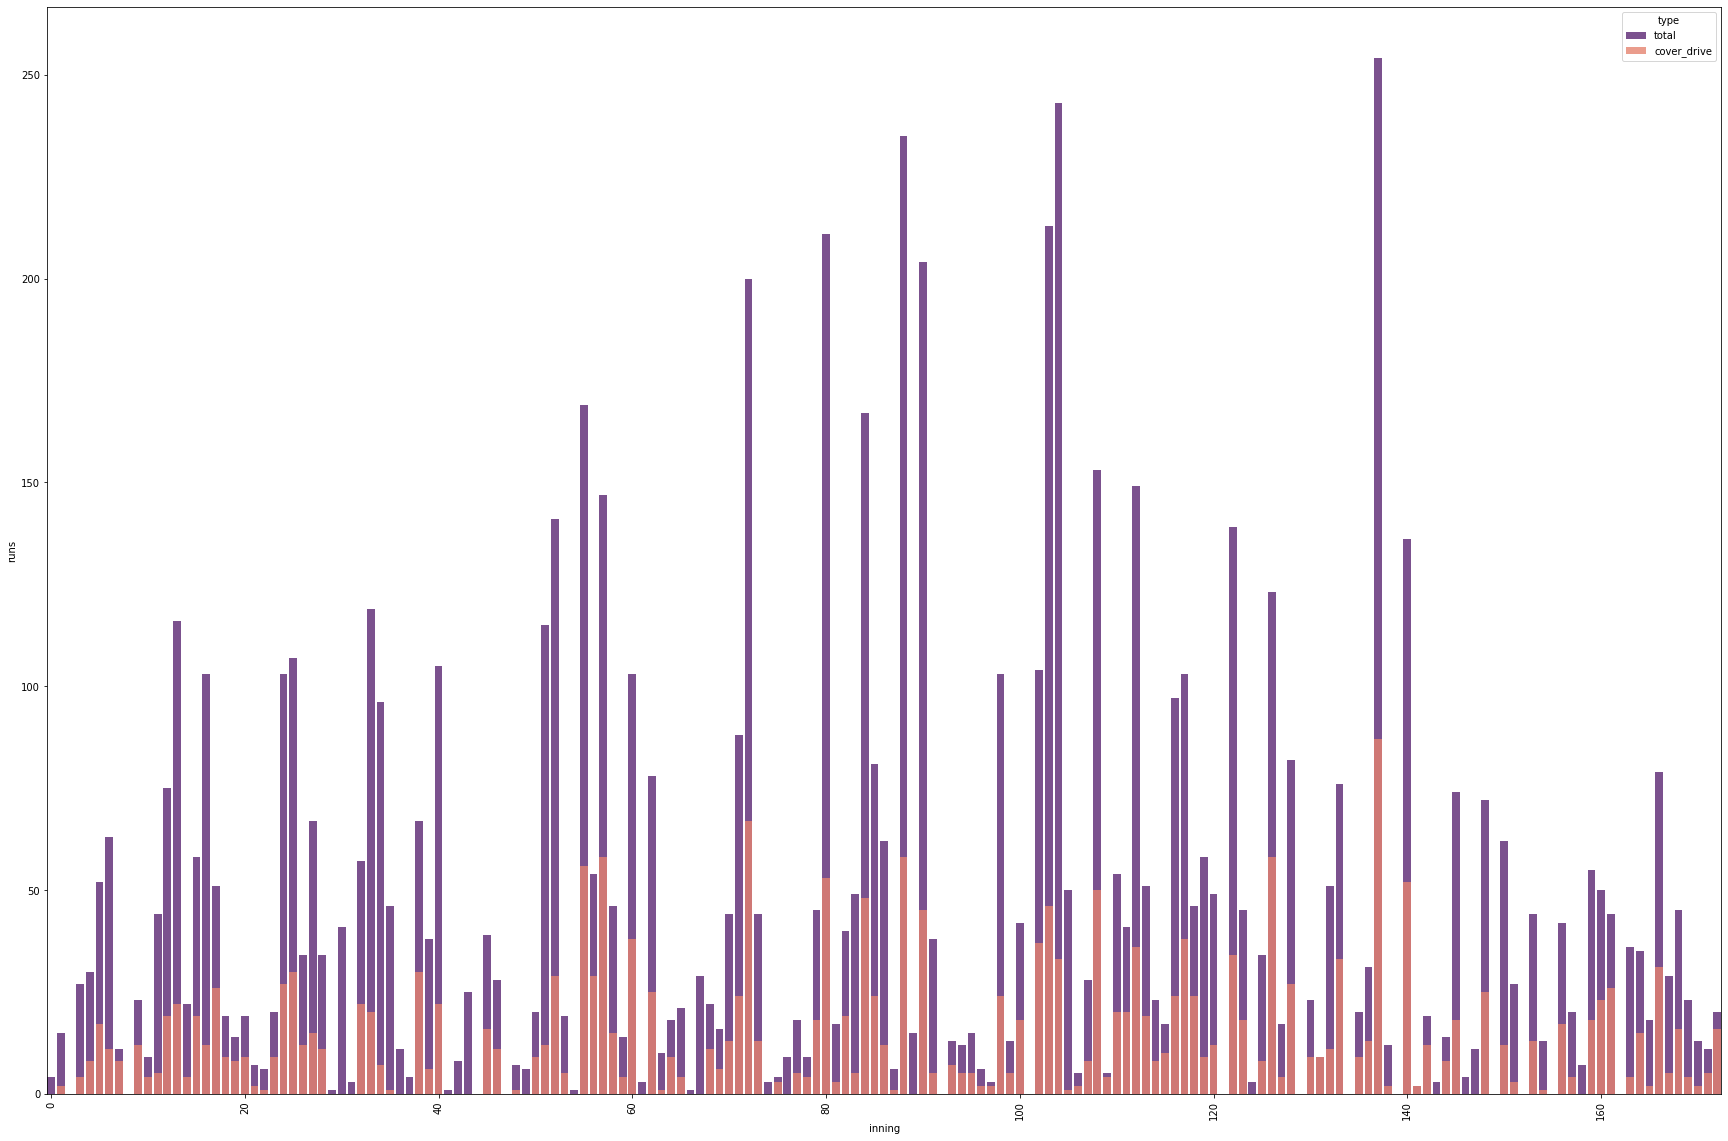

In [18]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
#sns.set_theme()
colours = ['#5f187f','#f8765c']
custom = sns.set_palette(sns.color_palette(colours))
sns.barplot(data = runs_df, x=runs_df.inning, y=runs_df.runs, alpha=0.8, ax=ax1, palette=custom, hue=runs_df.type, dodge=False)
ax1.set_xticklabels(labels=[x for x in range(len(kohli_innings))], rotation=90);
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.margins(x=0)

Ok, so we cant really tell much of what is going on based on the graph, so maybe we can figure out what percentage or runs came off of cover drives and also what percentage of shots played (i.e. balls faced) were cover drives. And then we should also get a list of when the first cover drive was.


In [ ]:
perc_runs_cd = []
for i in range(len(kohli_innings)):
    try:
        perc_runs_cd.append(round(int(kohli_cover_drive_stats[i]['runs'])/int(kohli_innings[i]['runs']), 2))
    except ZeroDivisionError:
        perc_runs_cd.append(0)

In [ ]:
perc_runs_cd

[0.0,
 0.13,
 0,
 0.15,
 0.27,
 0.33,
 0.17,
 0.73,
 0,
 0.52,
 0.44,
 0.11,
 0.25,
 0.19,
 0.18,
 0.33,
 0.12,
 0.51,
 0.47,
 0.57,
 0.47,
 0.29,
 0.17,
 0.45,
 0.26,
 0.28,
 0.35,
 0.22,
 0.32,
 0.0,
 0.0,
 0.0,
 0.39,
 0.17,
 0.07,
 0.02,
 0.0,
 0.0,
 0.45,
 0.16,
 0.21,
 0.0,
 0.0,
 0.0,
 0,
 0.41,
 0.39,
 0,
 0.14,
 0.0,
 0.45,
 0.1,
 0.21,
 0.26,
 0.0,
 0.33,
 0.54,
 0.39,
 0.33,
 0.29,
 0.37,
 0.0,
 0.32,
 0.1,
 0.5,
 0.19,
 0.0,
 0.0,
 0.5,
 0.38,
 0.3,
 0.27,
 0.34,
 0.3,
 0.0,
 0.75,
 0.0,
 0.28,
 0.44,
 0.4,
 0.25,
 0.18,
 0.47,
 0.1,
 0.29,
 0.3,
 0.19,
 0.17,
 0.25,
 0.0,
 0.22,
 0.13,
 0,
 0.54,
 0.42,
 0.33,
 0.33,
 0.67,
 0.23,
 0.38,
 0.43,
 0,
 0.36,
 0.22,
 0.14,
 0.02,
 0.4,
 0.29,
 0.33,
 0.8,
 0.37,
 0.49,
 0.24,
 0.37,
 0.35,
 0.59,
 0.25,
 0.37,
 0.52,
 0.16,
 0.24,
 0,
 0.24,
 0.4,
 0.0,
 0.24,
 0.47,
 0.24,
 0.33,
 0,
 0.57,
 1.0,
 0.22,
 0.43,
 0,
 0.45,
 0.42,
 0.34,
 0.17,
 0,
 0.38,
 1.0,
 0.63,
 0.0,
 0.57,
 0.24,
 0.0,
 0.0,
 0.35,
 0,
 0.19,
 0.11,
 0,


In [20]:
def moving_average(nums, window_size=5):
    last_x_average = [None]*(window_size - 1)
    window_total = 0
    window_count = 0

    for i in range(len(nums)-window_size):
        last_x_average.append(round(sum(nums[i:i+window_size])/window_size, 5))

    return last_x_average

In [ ]:
moving_runs_cd = moving_average(perc_runs_cd)

<AxesSubplot:>

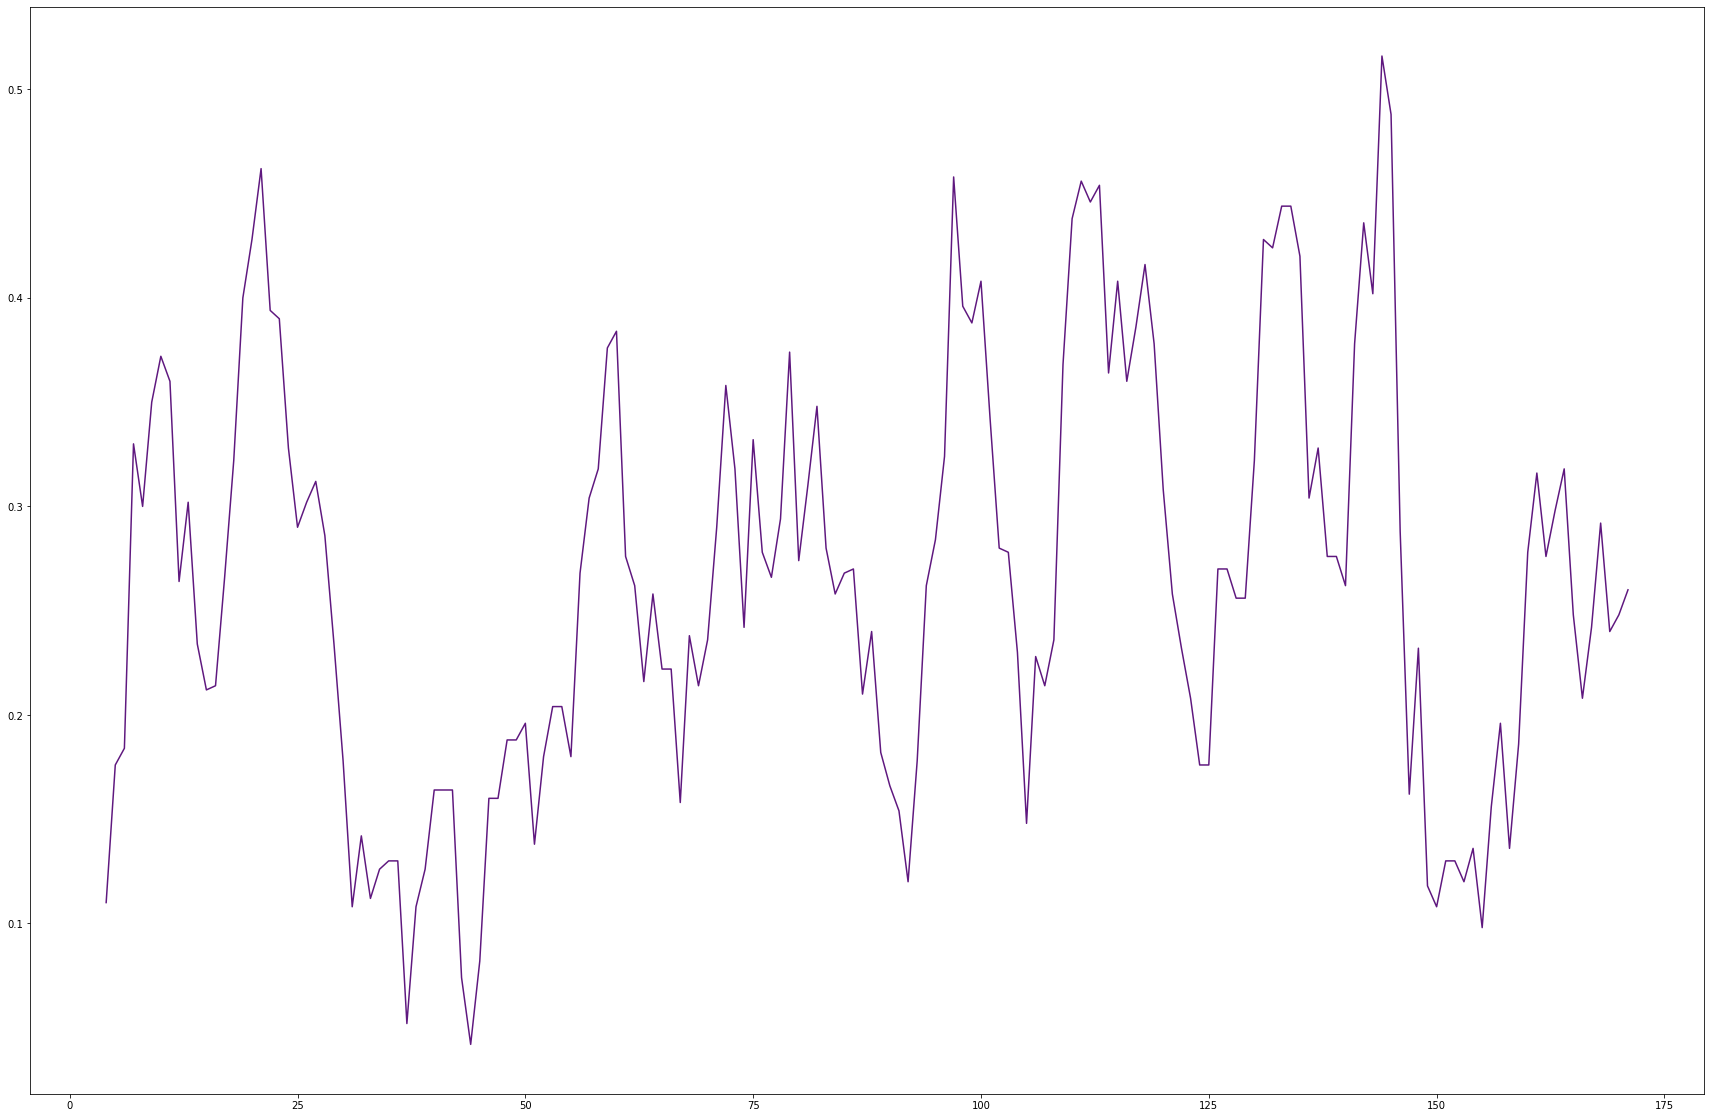

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(moving_runs_cd))), y=moving_runs_cd)

### Percentage of Runs in innings off cover drives


<AxesSubplot:>

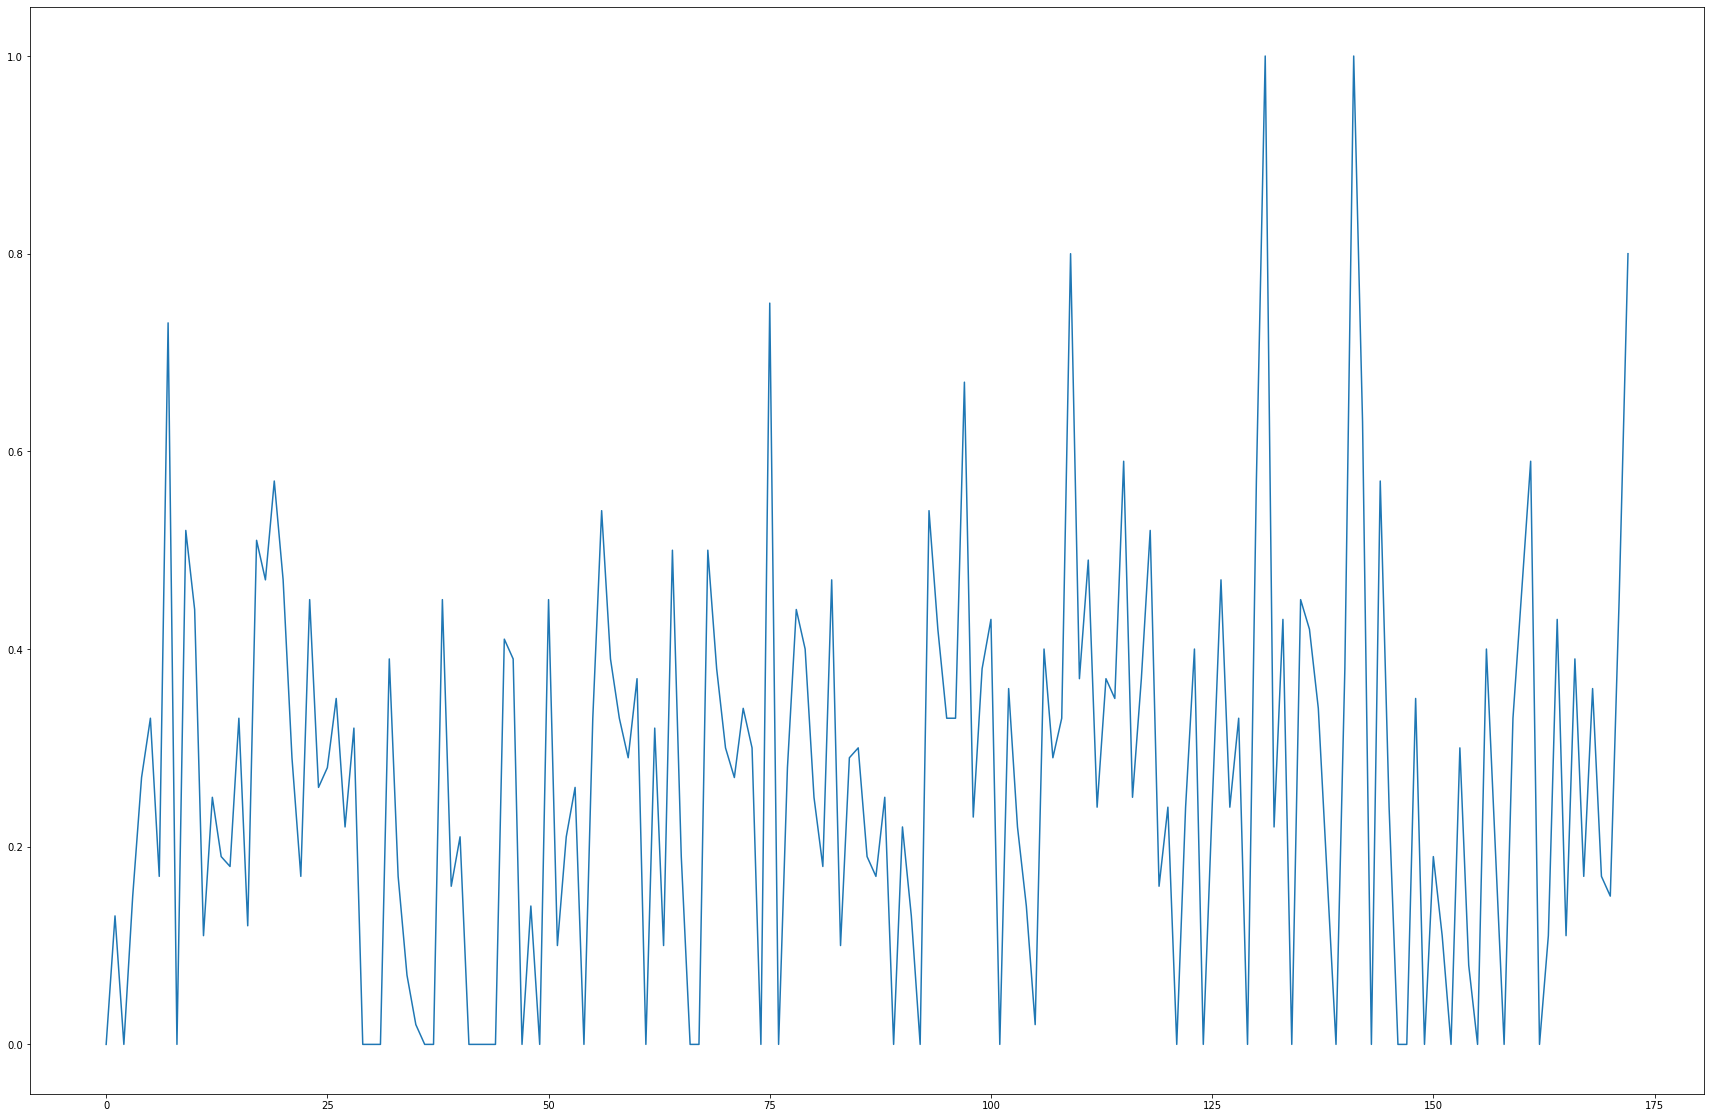

In [21]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(perc_runs_cd))), y=perc_runs_cd)

No trend in runs scored off of cover drives and out of form period

In [29]:
perc_balls_cd = []
for i in range(len(kohli_innings)):
    try:
        perc_balls_cd.append(round(int(kohli_cover_drive_stats[i]['balls_faced'])/int(kohli_innings[i]['balls_faced']), 2))
    except ZeroDivisionError:
        perc_balls_cd.append(0)

In [30]:
perc_balls_cd

[0.2,
 0.13,
 0.0,
 0.18,
 0.11,
 0.26,
 0.21,
 0.43,
 0.0,
 0.17,
 0.08,
 0.1,
 0.1,
 0.16,
 0.15,
 0.16,
 0.17,
 0.18,
 0.15,
 0.33,
 0.22,
 0.08,
 0.25,
 0.22,
 0.14,
 0.19,
 0.25,
 0.16,
 0.21,
 0.0,
 0.02,
 0.2,
 0.22,
 0.14,
 0.1,
 0.09,
 0.04,
 0.23,
 0.17,
 0.15,
 0.19,
 0.38,
 0.17,
 0.06,
 0.0,
 0.2,
 0.18,
 0.0,
 0.27,
 0.22,
 0.15,
 0.17,
 0.14,
 0.11,
 0.18,
 0.18,
 0.22,
 0.18,
 0.13,
 0.27,
 0.19,
 0.2,
 0.2,
 0.05,
 0.22,
 0.16,
 0.0,
 0.18,
 0.27,
 0.33,
 0.24,
 0.15,
 0.19,
 0.2,
 0.0,
 0.29,
 0.0,
 0.12,
 0.18,
 0.14,
 0.17,
 0.11,
 0.23,
 0.07,
 0.22,
 0.21,
 0.13,
 0.18,
 0.23,
 0.14,
 0.18,
 0.23,
 0.0,
 0.19,
 0.18,
 0.24,
 0.22,
 0.25,
 0.21,
 0.24,
 0.25,
 0.18,
 0.28,
 0.17,
 0.09,
 0.02,
 0.08,
 0.33,
 0.19,
 0.15,
 0.18,
 0.24,
 0.24,
 0.23,
 0.18,
 0.17,
 0.22,
 0.22,
 0.3,
 0.13,
 0.17,
 1.0,
 0.14,
 0.27,
 0.38,
 0.12,
 0.23,
 0.17,
 0.18,
 0.0,
 0.2,
 0.42,
 0.24,
 0.15,
 0.0,
 0.28,
 0.28,
 0.3,
 0.18,
 0.0,
 0.24,
 0.43,
 0.26,
 0.13,
 0.3,
 0.1,
 0.12

In [31]:
moving_balls_cd = af.moving_average(perc_balls_cd)

In [32]:
moving_balls_cd

[None,
 None,
 None,
 None,
 None,
 0.124,
 0.136,
 0.152,
 0.238,
 0.202,
 0.214,
 0.178,
 0.156,
 0.09,
 0.122,
 0.118,
 0.134,
 0.148,
 0.164,
 0.162,
 0.198,
 0.21,
 0.192,
 0.206,
 0.22,
 0.182,
 0.176,
 0.21,
 0.192,
 0.19,
 0.162,
 0.128,
 0.118,
 0.13,
 0.116,
 0.136,
 0.15,
 0.118,
 0.12,
 0.126,
 0.136,
 0.156,
 0.224,
 0.212,
 0.19,
 0.16,
 0.162,
 0.122,
 0.088,
 0.13,
 0.174,
 0.164,
 0.162,
 0.19,
 0.158,
 0.15,
 0.156,
 0.166,
 0.174,
 0.178,
 0.196,
 0.198,
 0.194,
 0.198,
 0.182,
 0.172,
 0.166,
 0.126,
 0.122,
 0.166,
 0.188,
 0.204,
 0.234,
 0.236,
 0.222,
 0.156,
 0.166,
 0.136,
 0.122,
 0.118,
 0.146,
 0.122,
 0.144,
 0.166,
 0.144,
 0.16,
 0.168,
 0.172,
 0.162,
 0.194,
 0.178,
 0.172,
 0.192,
 0.156,
 0.148,
 0.156,
 0.168,
 0.166,
 0.216,
 0.22,
 0.232,
 0.234,
 0.226,
 0.232,
 0.224,
 0.194,
 0.148,
 0.128,
 0.138,
 0.142,
 0.154,
 0.186,
 0.218,
 0.2,
 0.208,
 0.214,
 0.212,
 0.208,
 0.204,
 0.218,
 0.208,
 0.208,
 0.364,
 0.348,
 0.342,
 0.392,
 0.382,
 0.228

<AxesSubplot:>

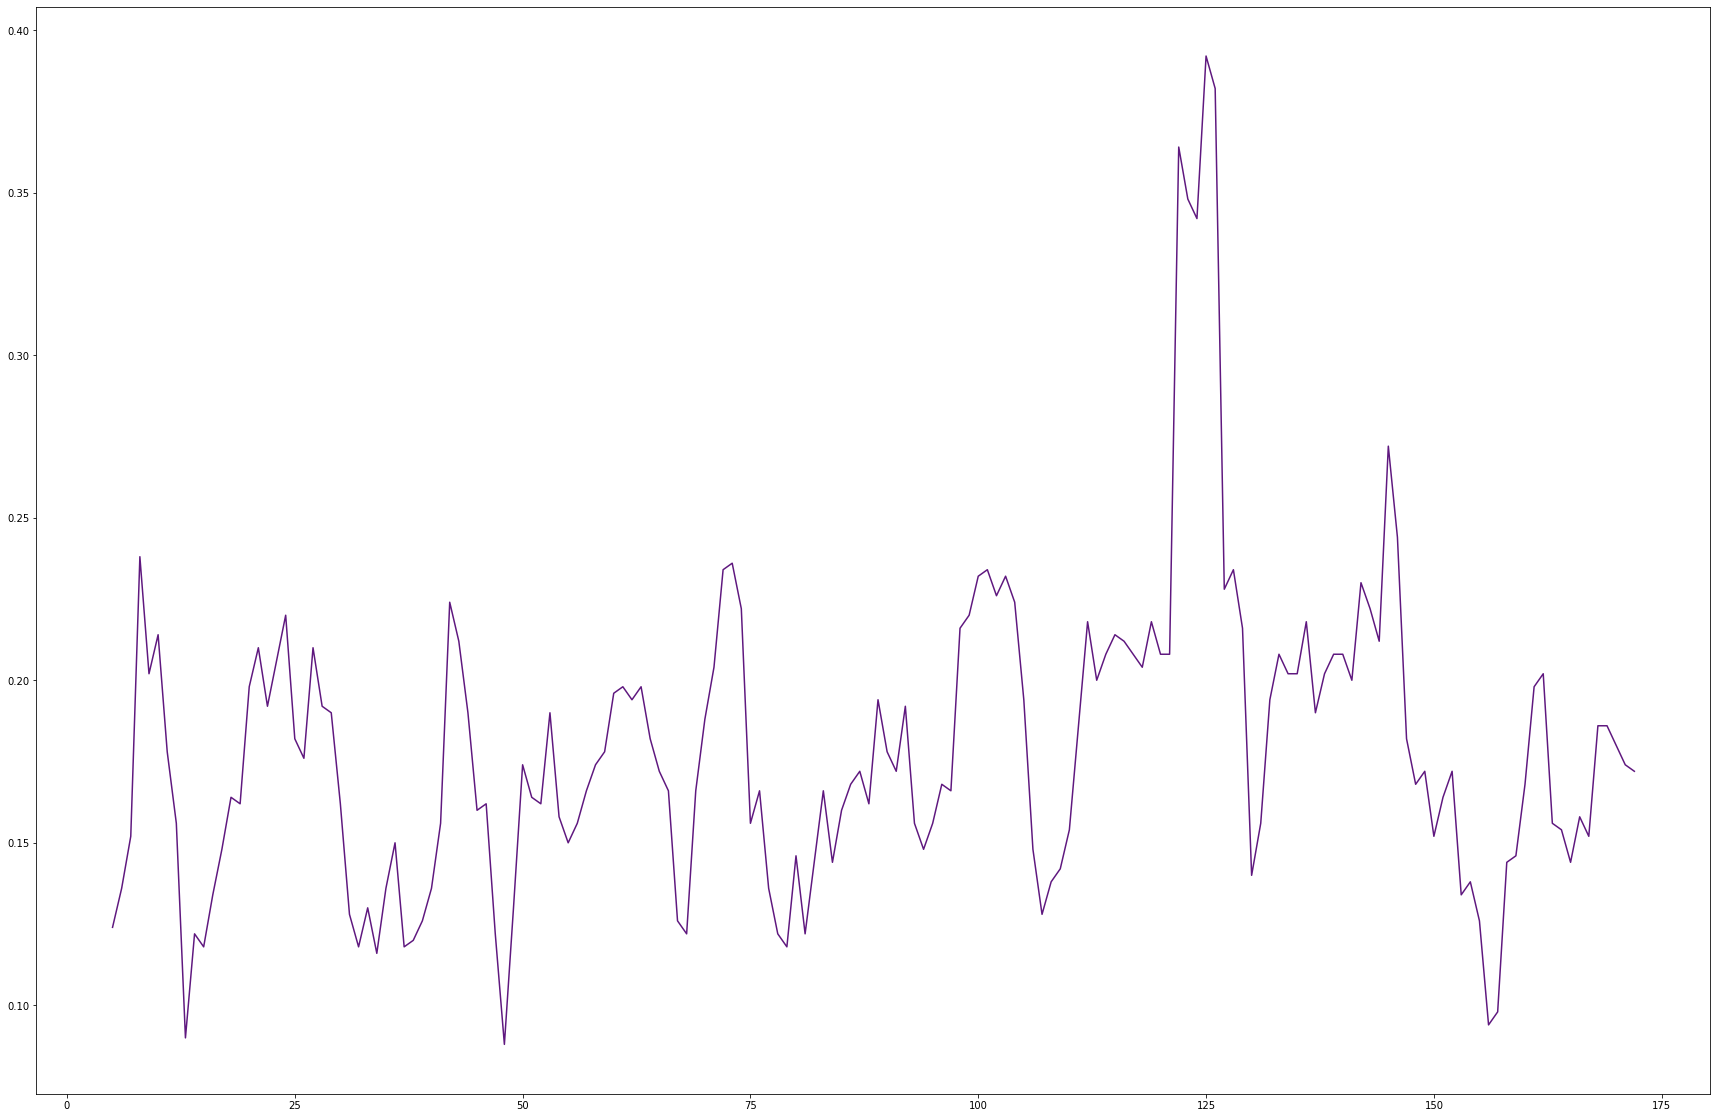

In [33]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(moving_balls_cd))), y=moving_balls_cd)

### Percentage of balls where cover drives are played

<AxesSubplot:>

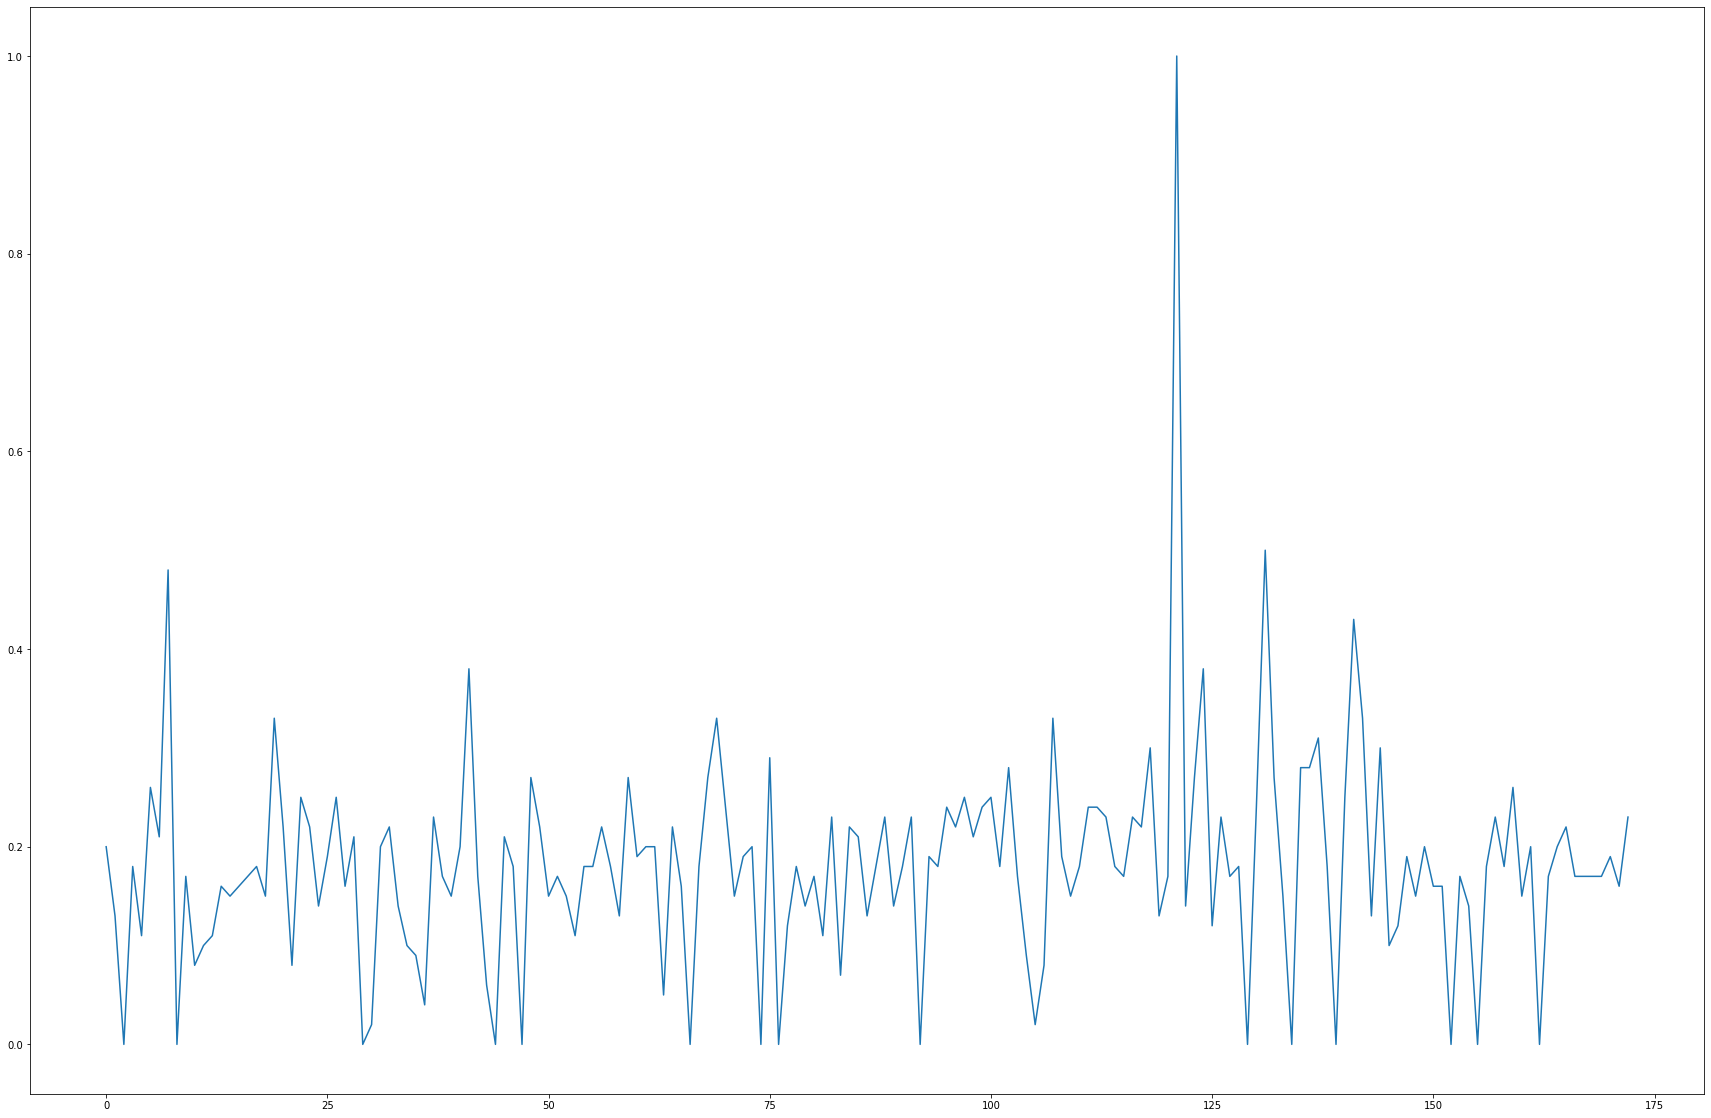

In [28]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(perc_balls_cd))), y=perc_balls_cd)

No real trend here either. If anything, Kohli plays less cover drives when out of form, which is completely opposite to our hypothesis

In [29]:
first_drive = []
for inning in kohli_coverdrive_comms:
    try:
        first_drive.append(inning.iloc[0].batsmanBallsFaced)
    except IndexError:
        first_drive.append(0)

### The ball faced where the first drive was played in each inning

<AxesSubplot:>

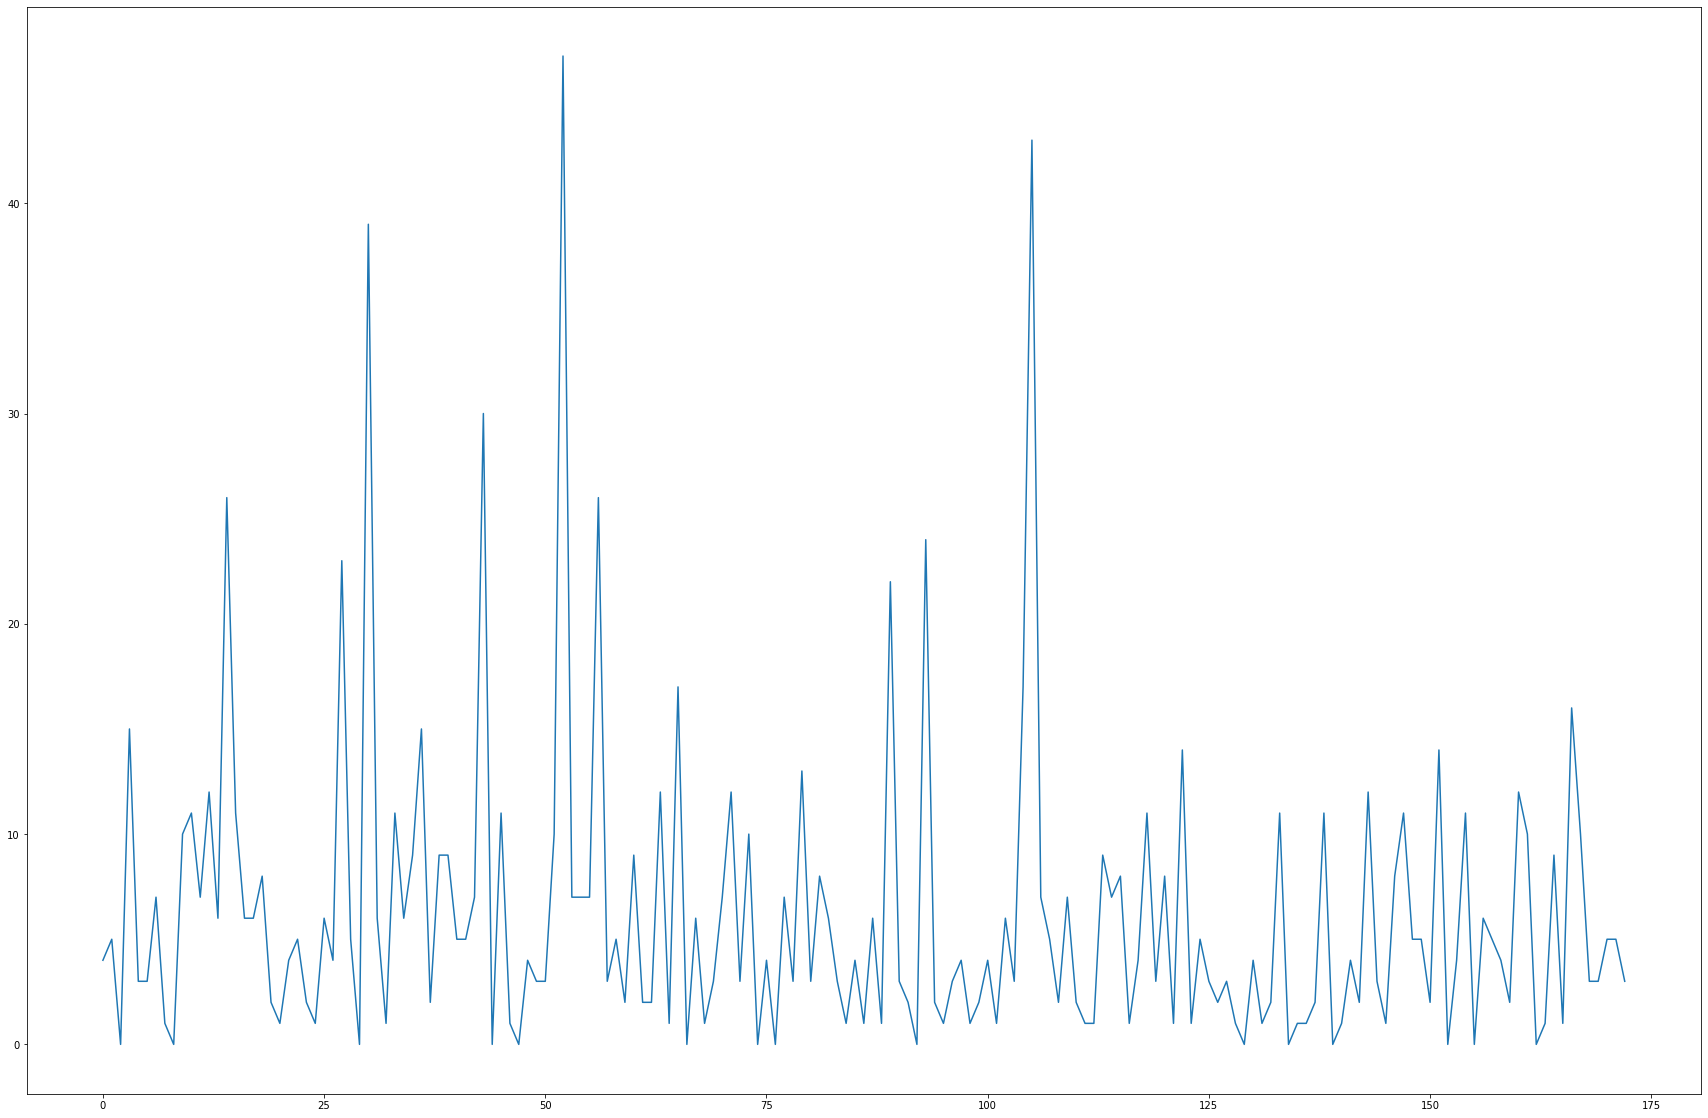

In [31]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(first_drive))), y=first_drive)

Again, no real trend here. We can basically conclude that Kohli plays cover drives the same amount when in and out of form.
Here we can conclude that in fact, the reason for Virat's low form was not the shot choice per se, but it could have resulted as a lack of ability to _adapt_ when forma was poor. One of the most famous examples of this is Sachin Tendulkar's 241 against Australia where he only scored on one side of the wicket. This goes to show the adaptibility of Virat as a player. The best batsman of consistently adapt their game to the circumstances and to their form as well.

Lets get the average runs per coverdrive

In [37]:
average_runs_per_drive = [x['runs']/x['balls_faced'] if x['balls_faced'] != 0 else 0 for x in kohli_cover_drive_stats]

<AxesSubplot:>

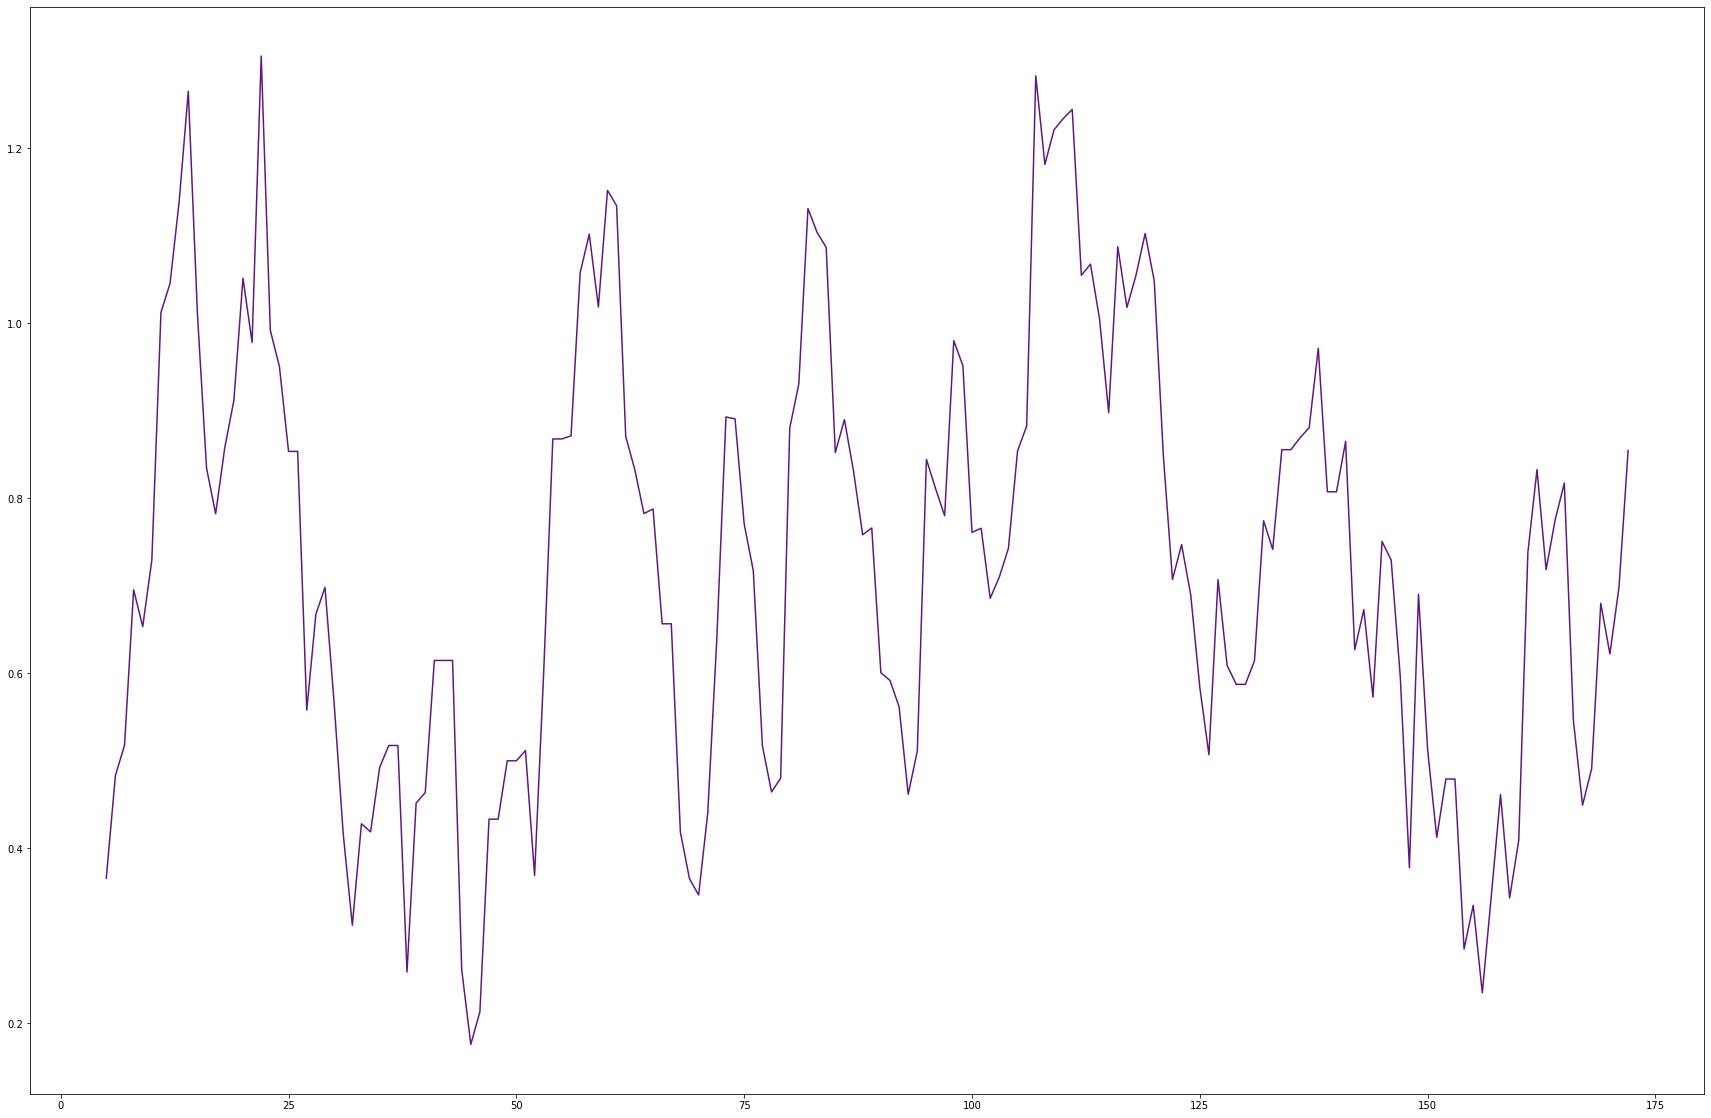

In [39]:
mv_av_runs_per_drive = af.moving_average(average_runs_per_drive)
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(mv_av_runs_per_drive))), y=mv_av_runs_per_drive)

<AxesSubplot:>

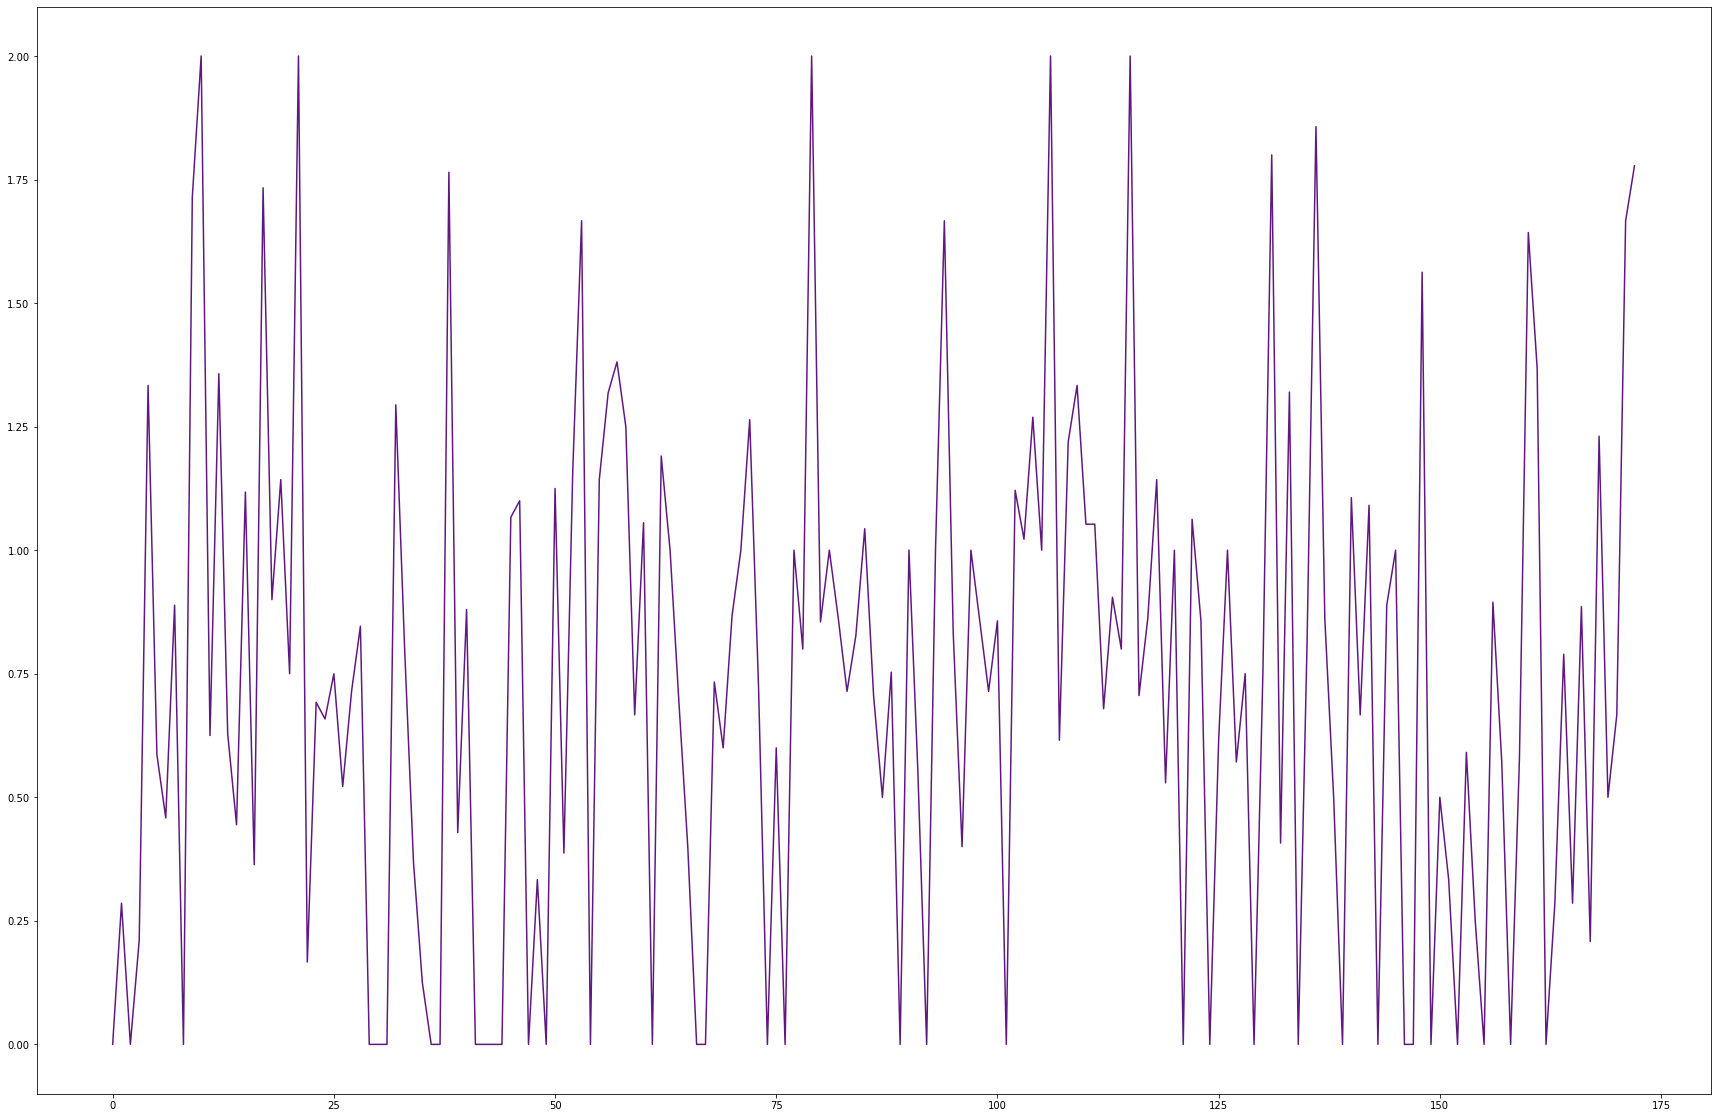

In [38]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(average_runs_per_drive))), y=average_runs_per_drive)

## Lets make a innings story graph

The goal will be to create an innings 'story'. The point of this is because we want to see what shot was played in each point of the innings. We often hear about how batsman 'build' innings, what doe this mean pratically? Usually when we talk about a batsman building their innings, we usually talk about how they are cautious at first, have a limited selection of shots, and then slowly start to expand their repitoir as they become more confident at the crease. The things to look out for then include:
- shot selection/range of shots played
- strike rate
- boundary rate
- control percentage

If we can map out these things, then we may be able to see how a batsman builds an innings. We can then also see how a batsman plays when in form and when out of form.

How will we visualize the innings?
- Strike rate: This can be a worm graph of the strike rate as the innings progresses
- Control percentage: we dont have a way to measure, but this would have been a percentage 
- Boundary Rate: boundaries per run scoring ball, and bar graph of total boundaries
- Shot selection, multi-coloured graph 

In [3]:
wsf.get_player_career_stats(KOHLI_ID)

{'bat_Span': '2011-2022',
 'bat_Mat': '102',
 'bat_Inns': '173',
 'bat_NO': '10',
 'bat_Runs': '8074',
 'bat_HS': '254*',
 'bat_Ave': '49.53',
 'bat_BF': '14499',
 'bat_SR': '55.68',
 'bat_100': '27',
 'bat_50': '28',
 'bat_0': '14',
 'bat_4s': '910',
 'bat_6s': '24',
 'bowl_Span': '2011-2022',
 'bowl_Mat': '102',
 'bowl_Inns': '11',
 'bowl_Overs': '29.1',
 'bowl_Mdns': '2',
 'bowl_Runs': '84',
 'bowl_Wkts': '0',
 'bowl_Econ': '2.88',
 'bowl_5': '0',
 'bowl_10': '0',
 'field_Span': '2011-2022',
 'field_Mat': '102',
 'field_Inns': '195',
 'field_Dis': '102',
 'field_Ct': '102',
 'field_St': '0',
 'field_Ct Wk': '0',
 'field_Ct Fi': '102',
 'field_MD': '3 (3ct 0st)',
 'field_D/I': '0.523'}

## Flick shot analysis

In [11]:
flick_primary_kw = [
    'flick'
]
flick_search_kw = [
    'tuck',
    'clipped',
    'clip',
    ('pads', 0.3),
    ('pad ', 0.3),
    'on the pads',
    #('leg side', 0.25),
    ('leg', 0.3),
    ('square', 0.19),
    'glance'
    'off the pads',
    'off his pads',
    ('nudge', 0.3),
    ('pick', 0.3),
    ('straight', 0.3),
    #('square leg', 0.25),
    ('whip', 0.4),
    'on the legs',
    ('work', 0.25),
    ('midwicket', 0.3),
    ('on side', 0.25),
    ('across', 0.3)
]
flick_exlude_words = [
    'run out', 'bumper', 'sweep', 'swept',
    'pull', 'drive', 'cover-drive', ('cover', 0.3),
    'bouncer', 'short ball', 'stays back',
    'backfoot', 'top edge',
    'lets one go', 'easy leave', 'leaves the ball', 'padded away',
    ('off side', 0.25), 'cut', 'left alone', ('point', 0.25), ('defend', 0.3), ('push', 0.25)
]

In [12]:
kohli_flick_shot_comms = af.search_shots_in_comms(kohli_comms, flick_search_kw, flick_exlude_words, flick_primary_kw, threshold=0.49)

In [13]:
flick_innings = []

for inning in kohli_flick_shot_comms:
    try:
        flick_innings.append(af.analyse_batting_inning(inning))
    except IndexError:
        flick_innings.append(
            {
                'runs': 0,
                'dismissals': 0,
                'balls': 0,
                'sr': 0,
                'average': 0,
                'dot_balls': 0,
                'ones': 0, 
                'twos': 0,
                'threes': 0, 
                'fours': 0,
                'fives': 0,
                'sixes': 0,
                'how-out': None,
                'total_balls_faced': 0,
                'fours_per_ball': 0,
                'sixes_per_ball': 0,
                'dots_per_ball': 0
            }
        )

In [29]:
kohli_flick_stats = [af.analyse_batting_inning(inning) for inning in kohli_flick_shot_comms]

In [30]:
runs = []
for i in range(len(kohli_comms)):
    r = {'runs':kohli_flick_stats[i]['runs'], 'type':'flick','inning':i}
    r2 = {'runs':kohli_innings[i]['runs'], 'type':'total','inning':i}
    runs.append(r2)
    runs.append(r)

flick_runs_df = pd.DataFrame(runs)

In [31]:
pal = sns.color_palette('magma')

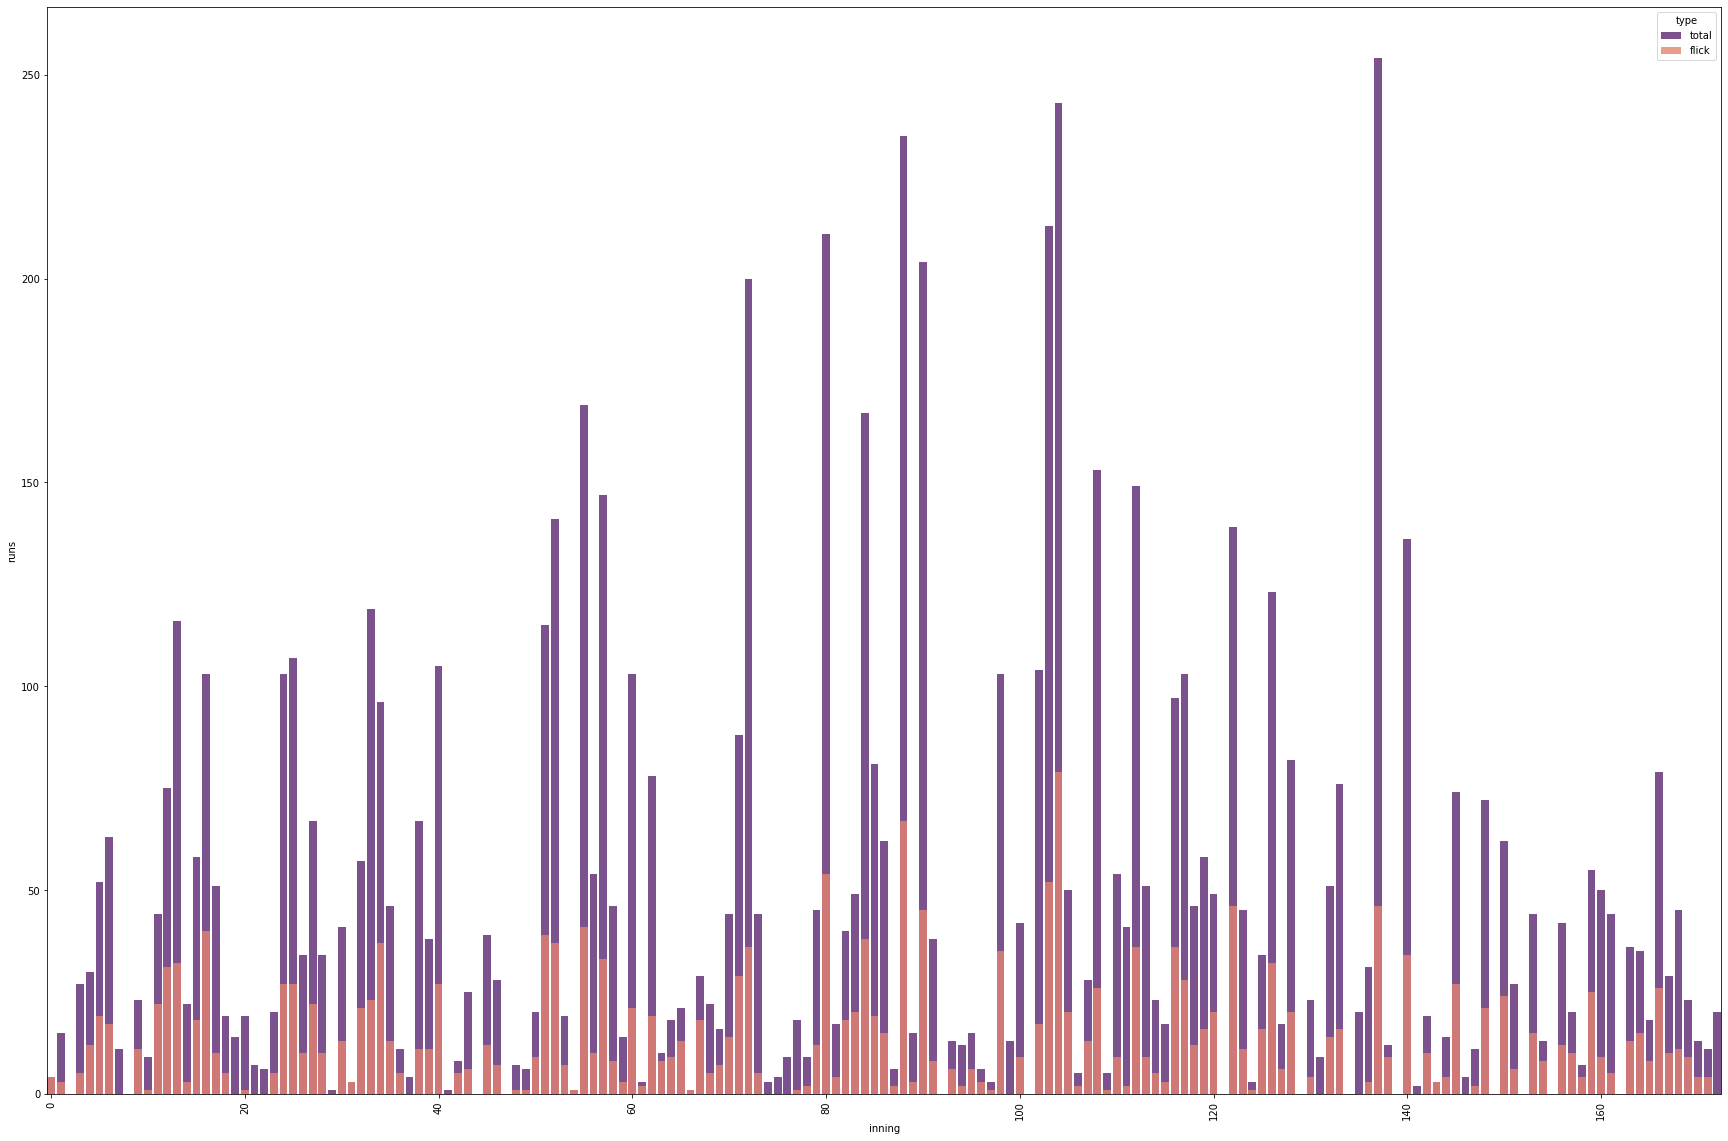

In [32]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
#sns.set_theme()
colours = ['#5f187f','#f8765c']
custom = sns.set_palette(sns.color_palette(colours))
sns.barplot(data = flick_runs_df, x=flick_runs_df.inning, y=flick_runs_df.runs, alpha=0.8, ax=ax1, palette=custom, hue=flick_runs_df.type, dodge=False)
ax1.set_xticklabels(labels=[x for x in range(len(kohli_comms))], rotation=90);
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.margins(x=0)

#### Perentage Flick shots

In [33]:
perc_runs_flick = []
for i in range(len(kohli_comms)):
    try:
        perc_runs_flick.append(round(int(kohli_flick_stats[i]['runs'])/int(kohli_innings[i]['runs']), 2))
    except ZeroDivisionError:
        perc_runs_flick.append(0)

<AxesSubplot:>

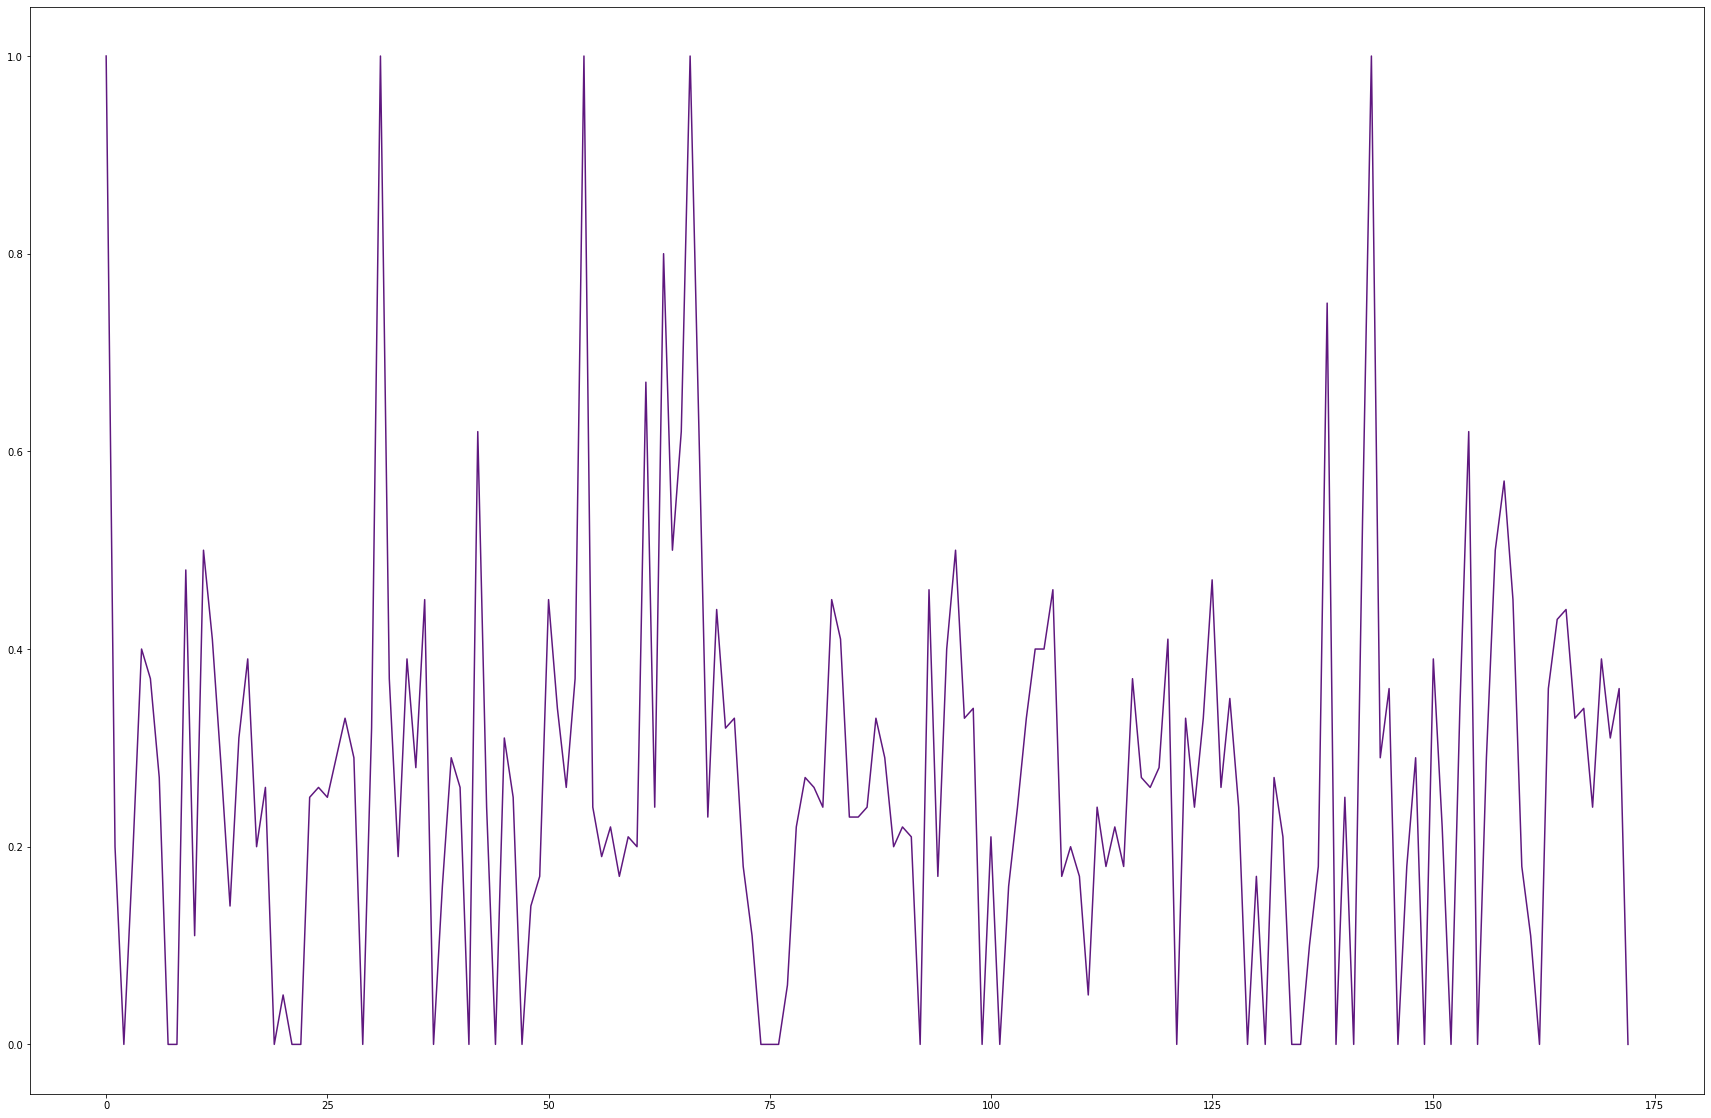

In [34]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(perc_runs_flick))), y=perc_runs_flick)

In [35]:
kohli_flick_stats[2]

{'runs': 0,
 'dismissals': 0,
 'balls_faced': 0,
 'sr': 0,
 'average': 0,
 'dot_balls': 0,
 'ones': 0,
 'twos': 0,
 'threes': 0,
 'fours': 0,
 'fives': 0,
 'sixes': 0,
 'how-out': None,
 'total_balls_faced': 0,
 'fours_per_ball': 0,
 'sixes_per_ball': 0,
 'dots_per_ball': 0}

In [36]:
perc_balls_flick = []
for i in range(len(kohli_comms)):
    try:
        perc_balls_flick.append(round(int(kohli_flick_stats[i]['balls_faced'])/int(kohli_innings[i]['balls_faced']), 2))
    except ZeroDivisionError:
        perc_balls_flick.append(0)
    except KeyError:
        print(i)
    

<AxesSubplot:>

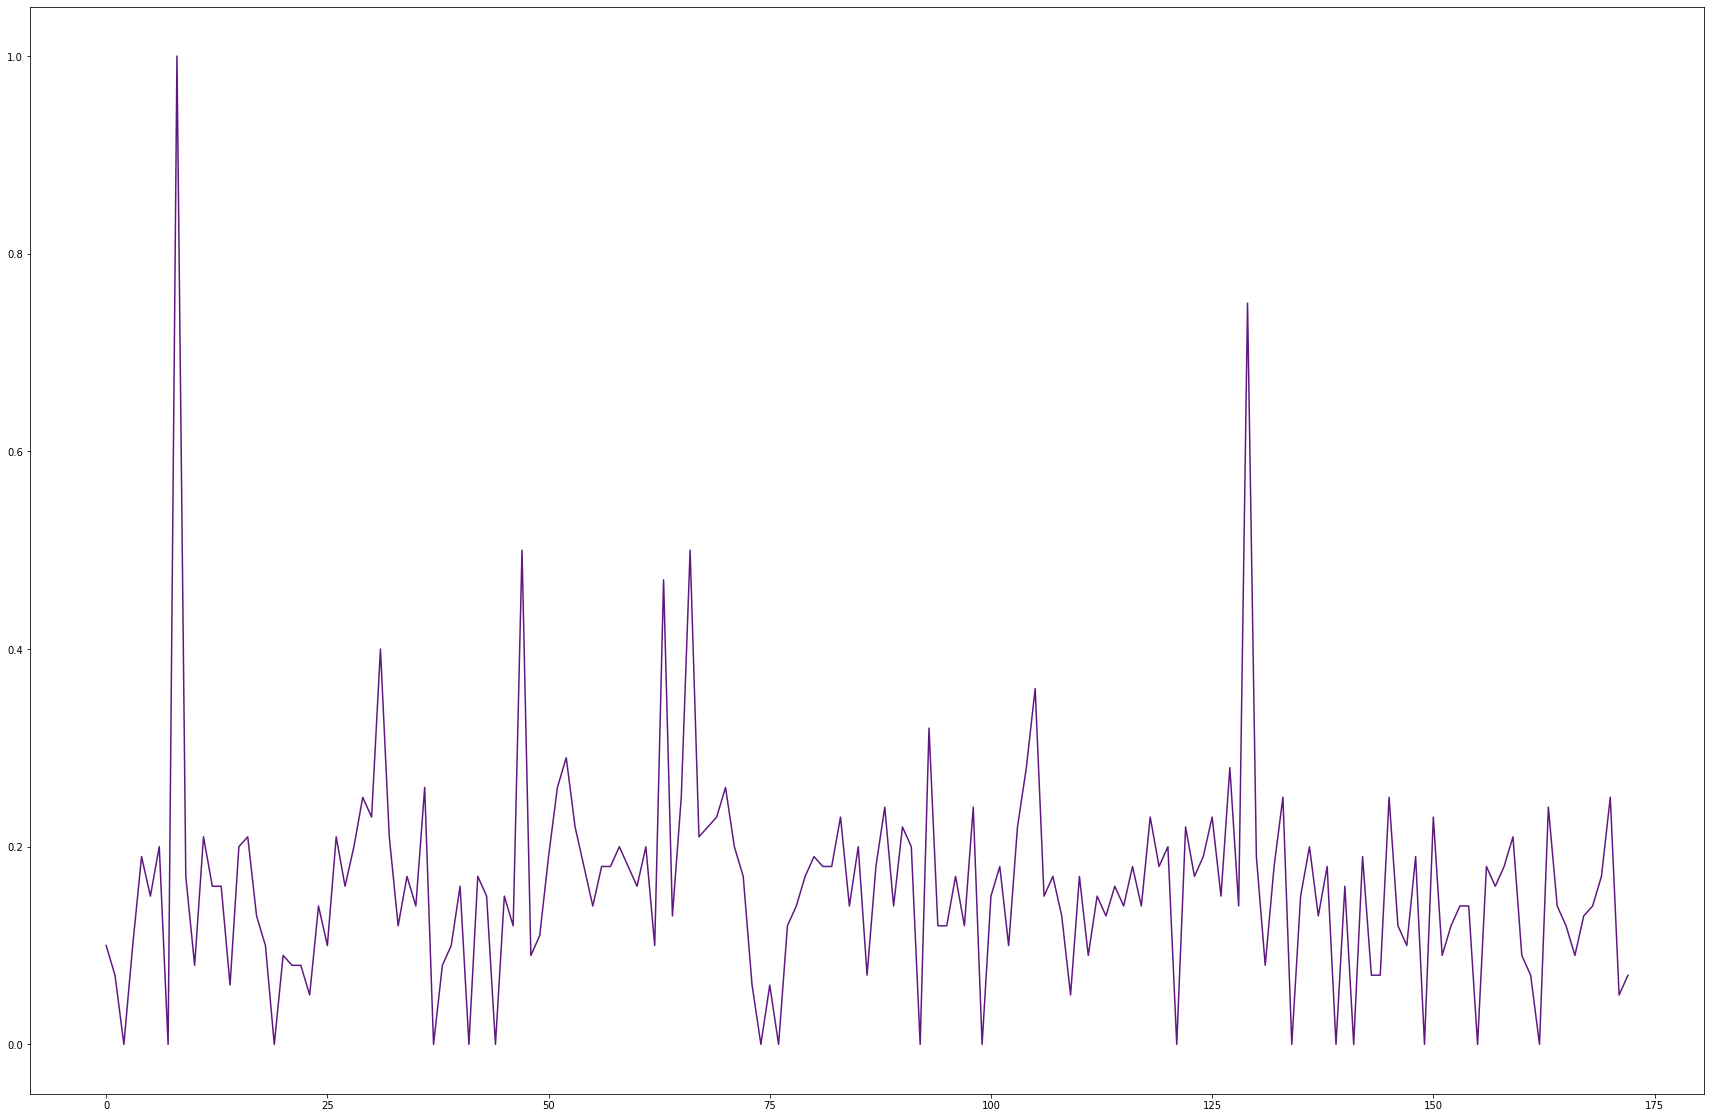

In [37]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(perc_balls_flick))), y=perc_balls_flick)

Same as the cover drives, I dont really see any trend in terms of flick shots either. Maybe it will be better to calculate rolling average for this as well, similar to how we did so for the batting average.

In [38]:
moving_perc_runs_flick = af.moving_average(perc_runs_flick)

<AxesSubplot:>

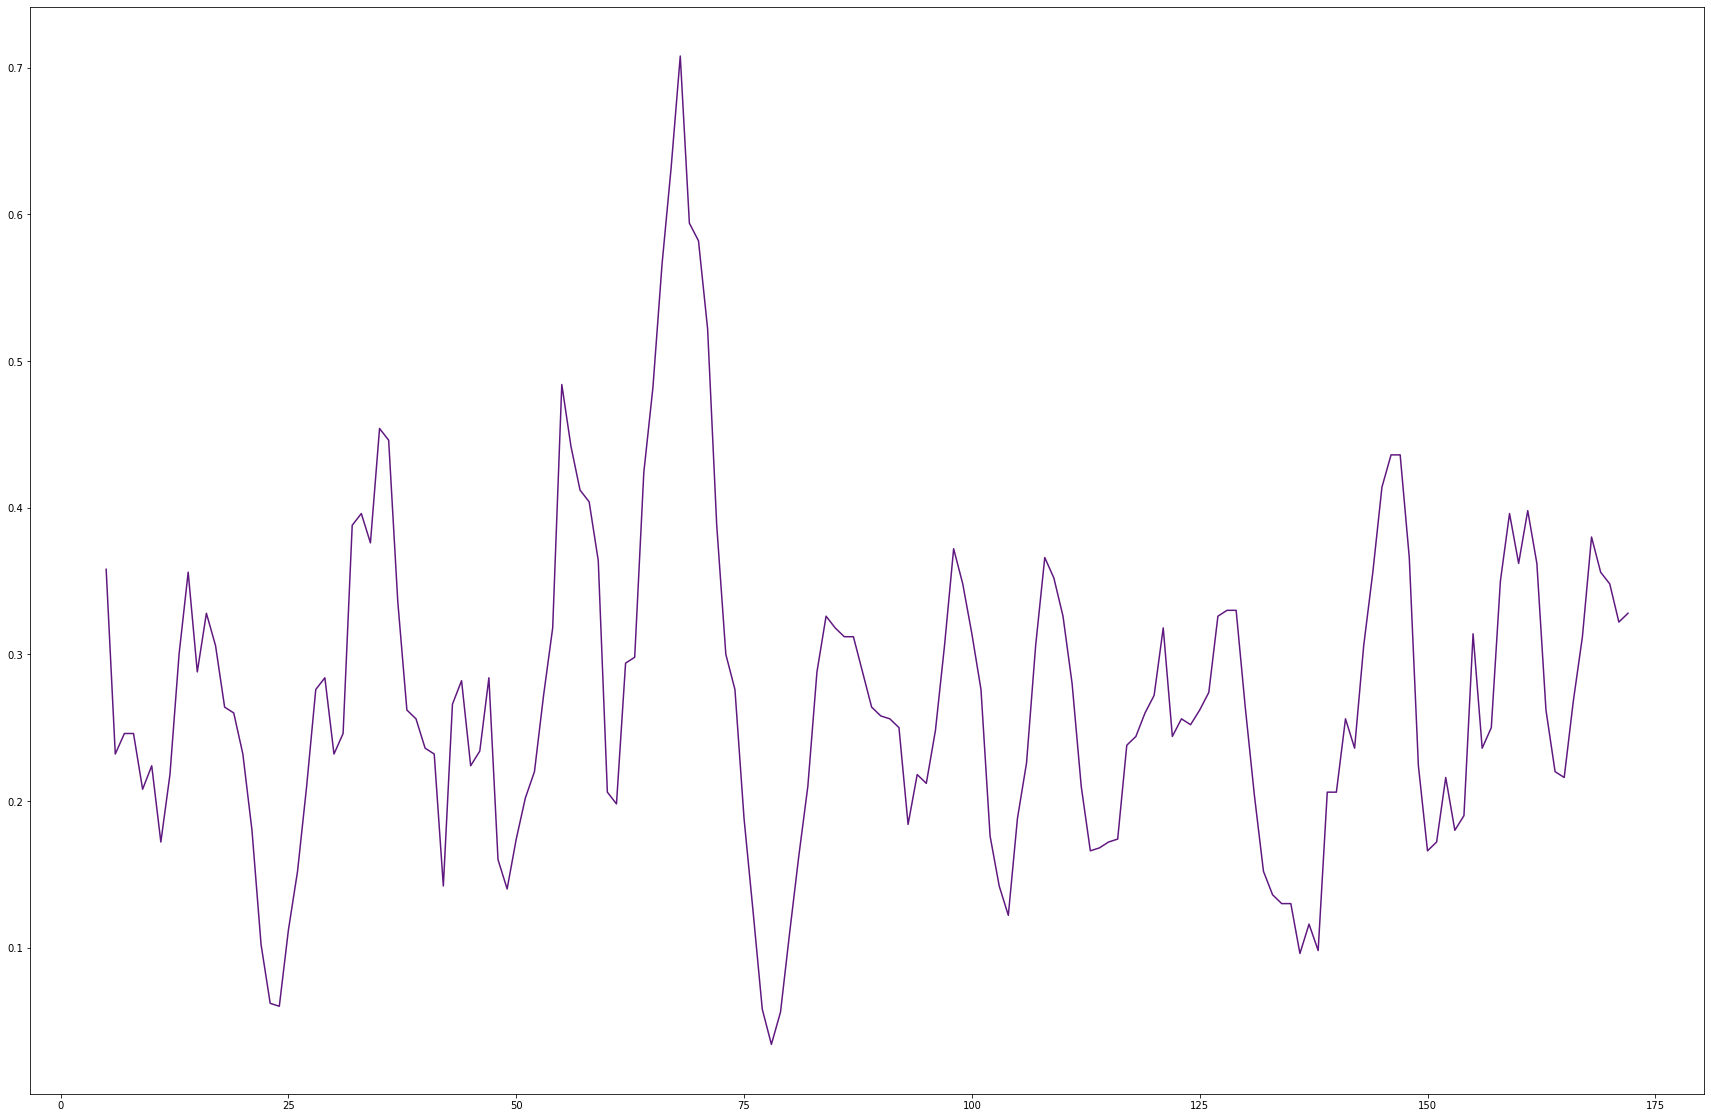

In [39]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(moving_perc_runs_flick))), y=moving_perc_runs_flick)

Nor covrdrives nor flick shots are netting Kohli less runs significantly. But actually it seems to be a collective dip between both of them. So basicaly Kohli is not playing his highest netting shots very much, and as a result he is getting bogged down and not scoring as freely

Let us confirm that this is the case, we can find all of Kohli's dot balls, and find out what the dot ball percentage is. Furthermore we can potentially also see if Kohli is defending more.

## Dot ball percentages

Dot balls, are deliveries in the comms where there was no run scored. So lets get all of those

In [15]:
dot_ball_comms = []

for i, comms in enumerate(kohli_comms):
    dot_balls = comms[comms.batsmanRuns == 0]

    dot_ball_comms.append(dot_balls)

In [16]:
dot_ball_stats = [af.analyse_batting_inning(comms) for comms in dot_ball_comms]

In [17]:
perc_balls_dots = af.fraction_of_total(dot_ball_stats, kohli_innings, 'balls_faced')

In [18]:
moving_balls_dots = af.moving_average(perc_balls_dots)

<AxesSubplot:>

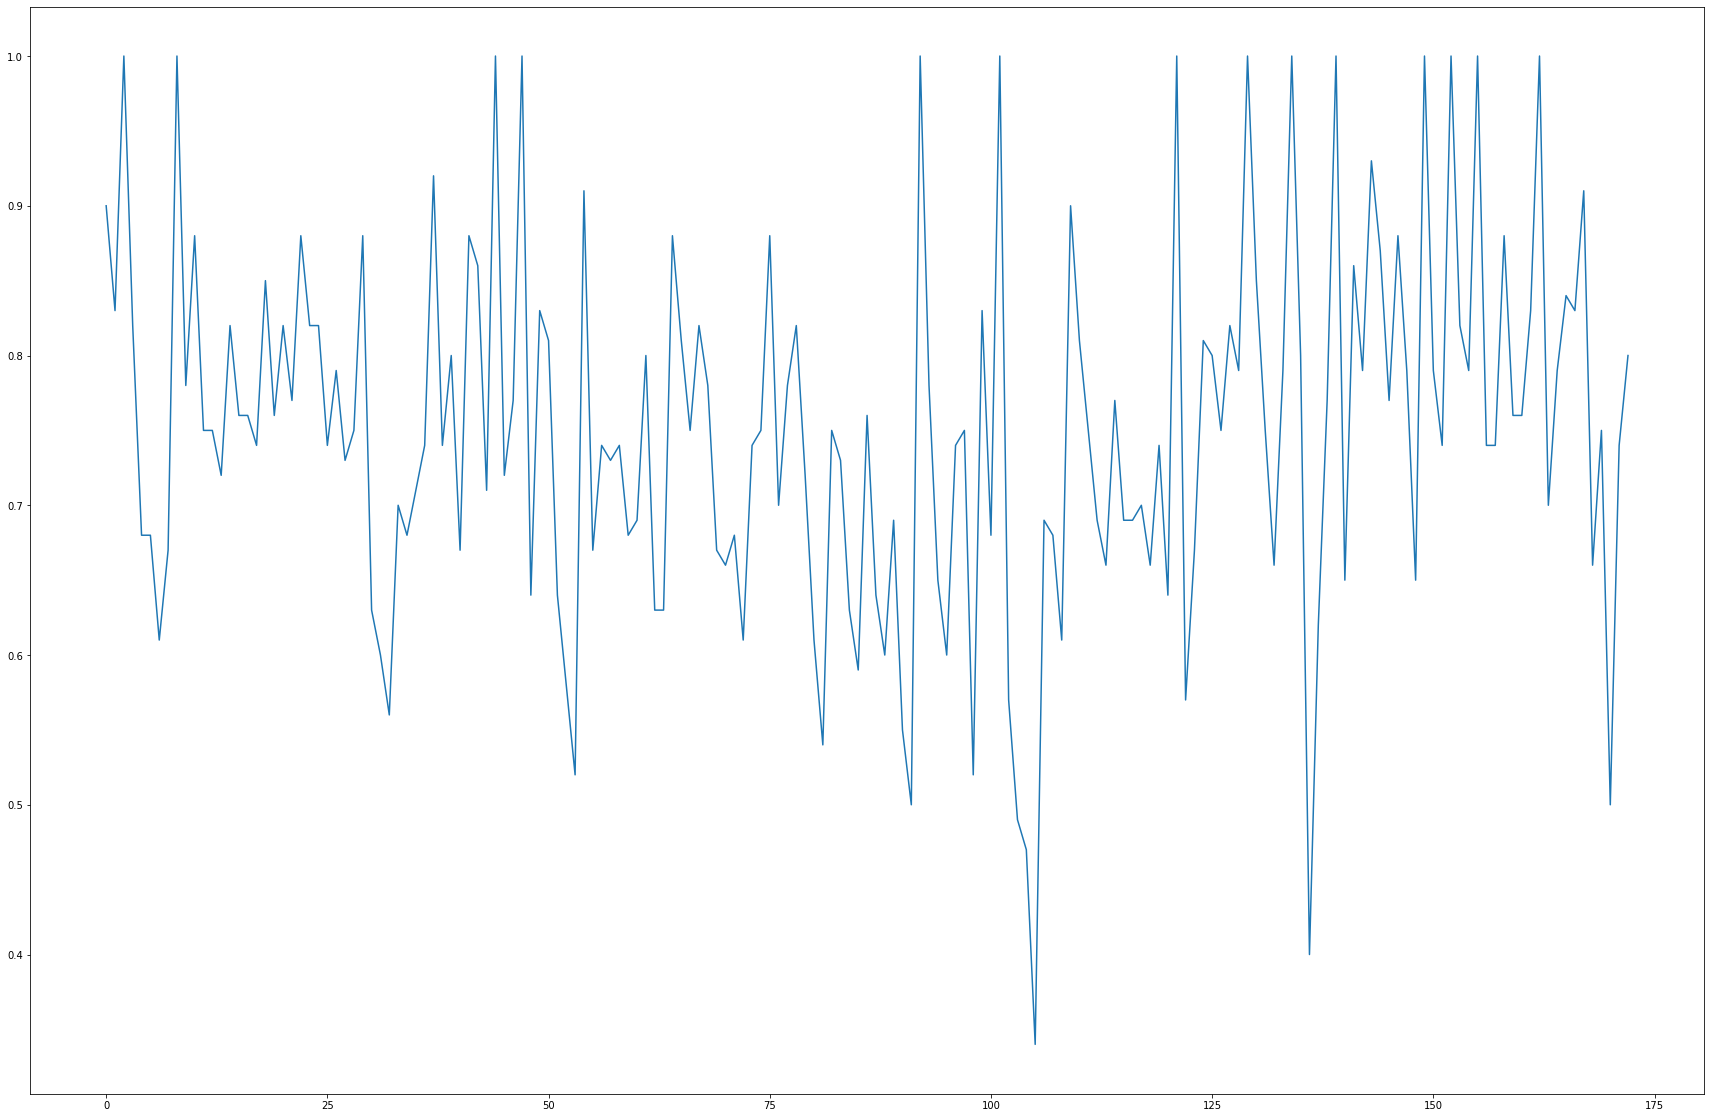

In [19]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(perc_balls_dots))), y=perc_balls_dots)

<AxesSubplot:>

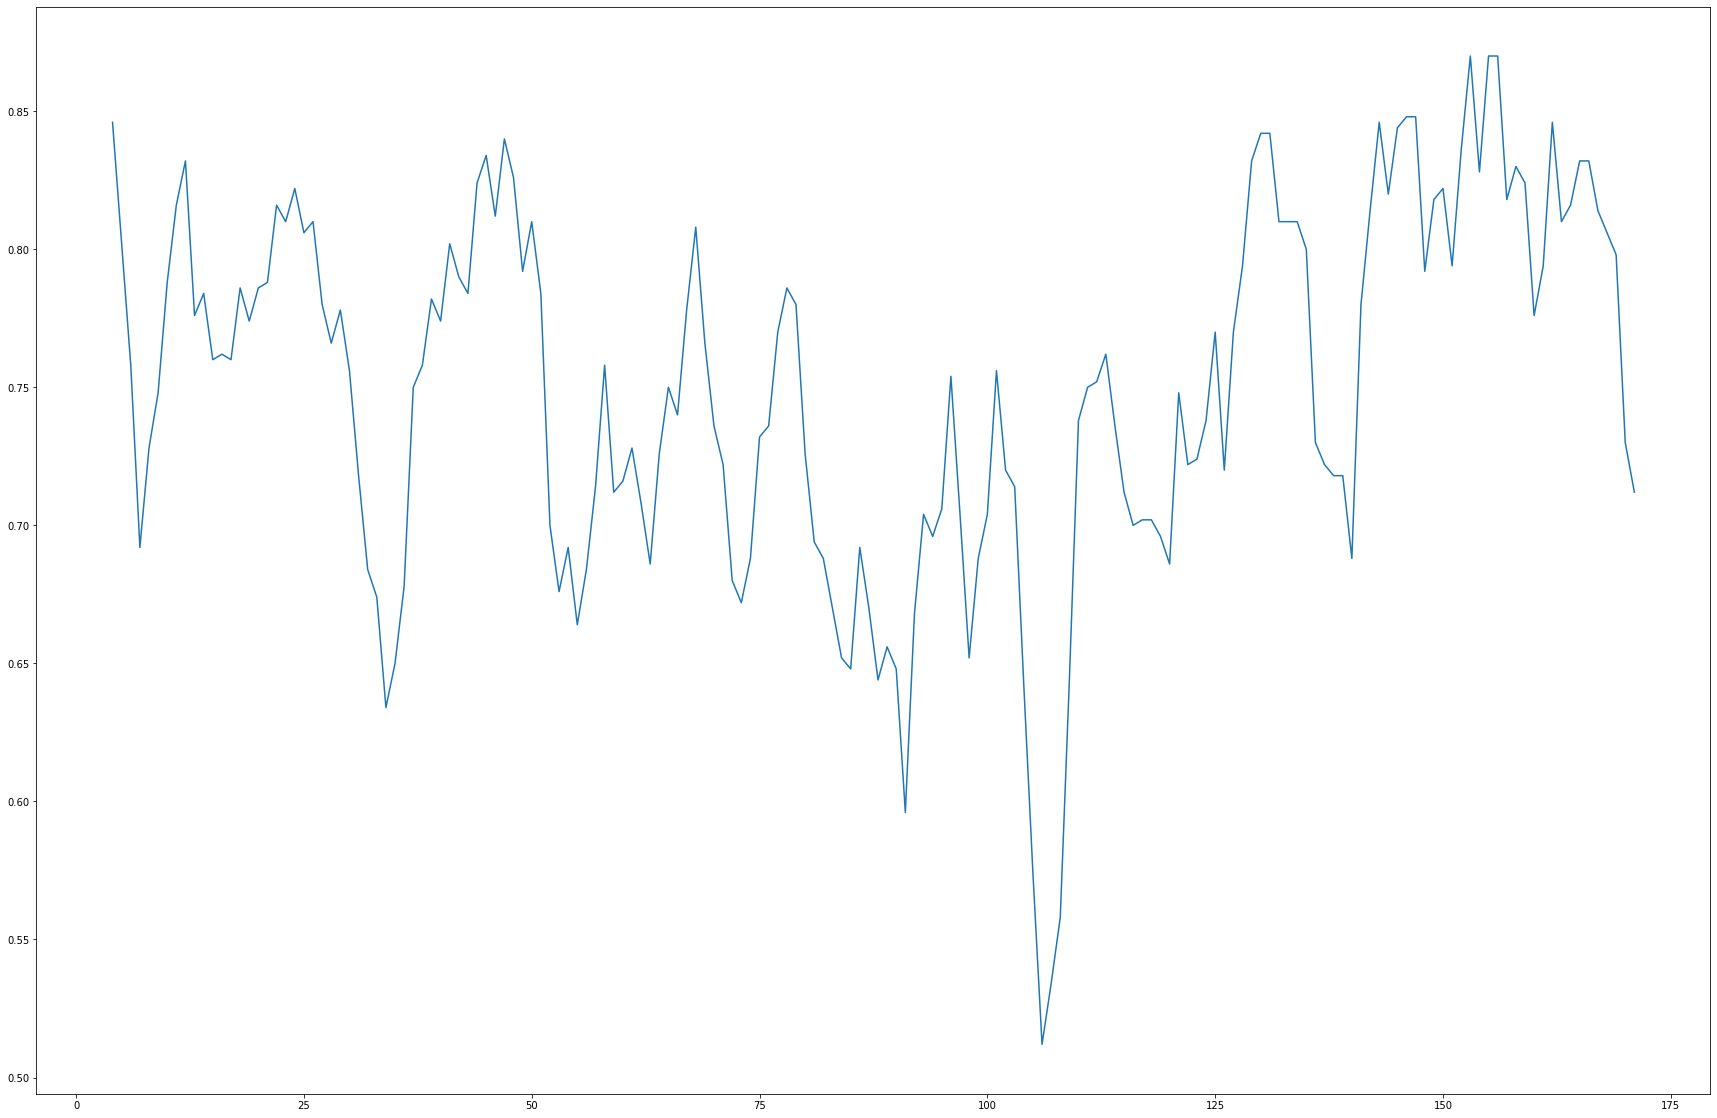

In [20]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(moving_balls_dots))), y=moving_balls_dots)

In [21]:
moving_balls_dots_smooth = af.moving_average(perc_balls_dots, window_size=10)

<AxesSubplot:>

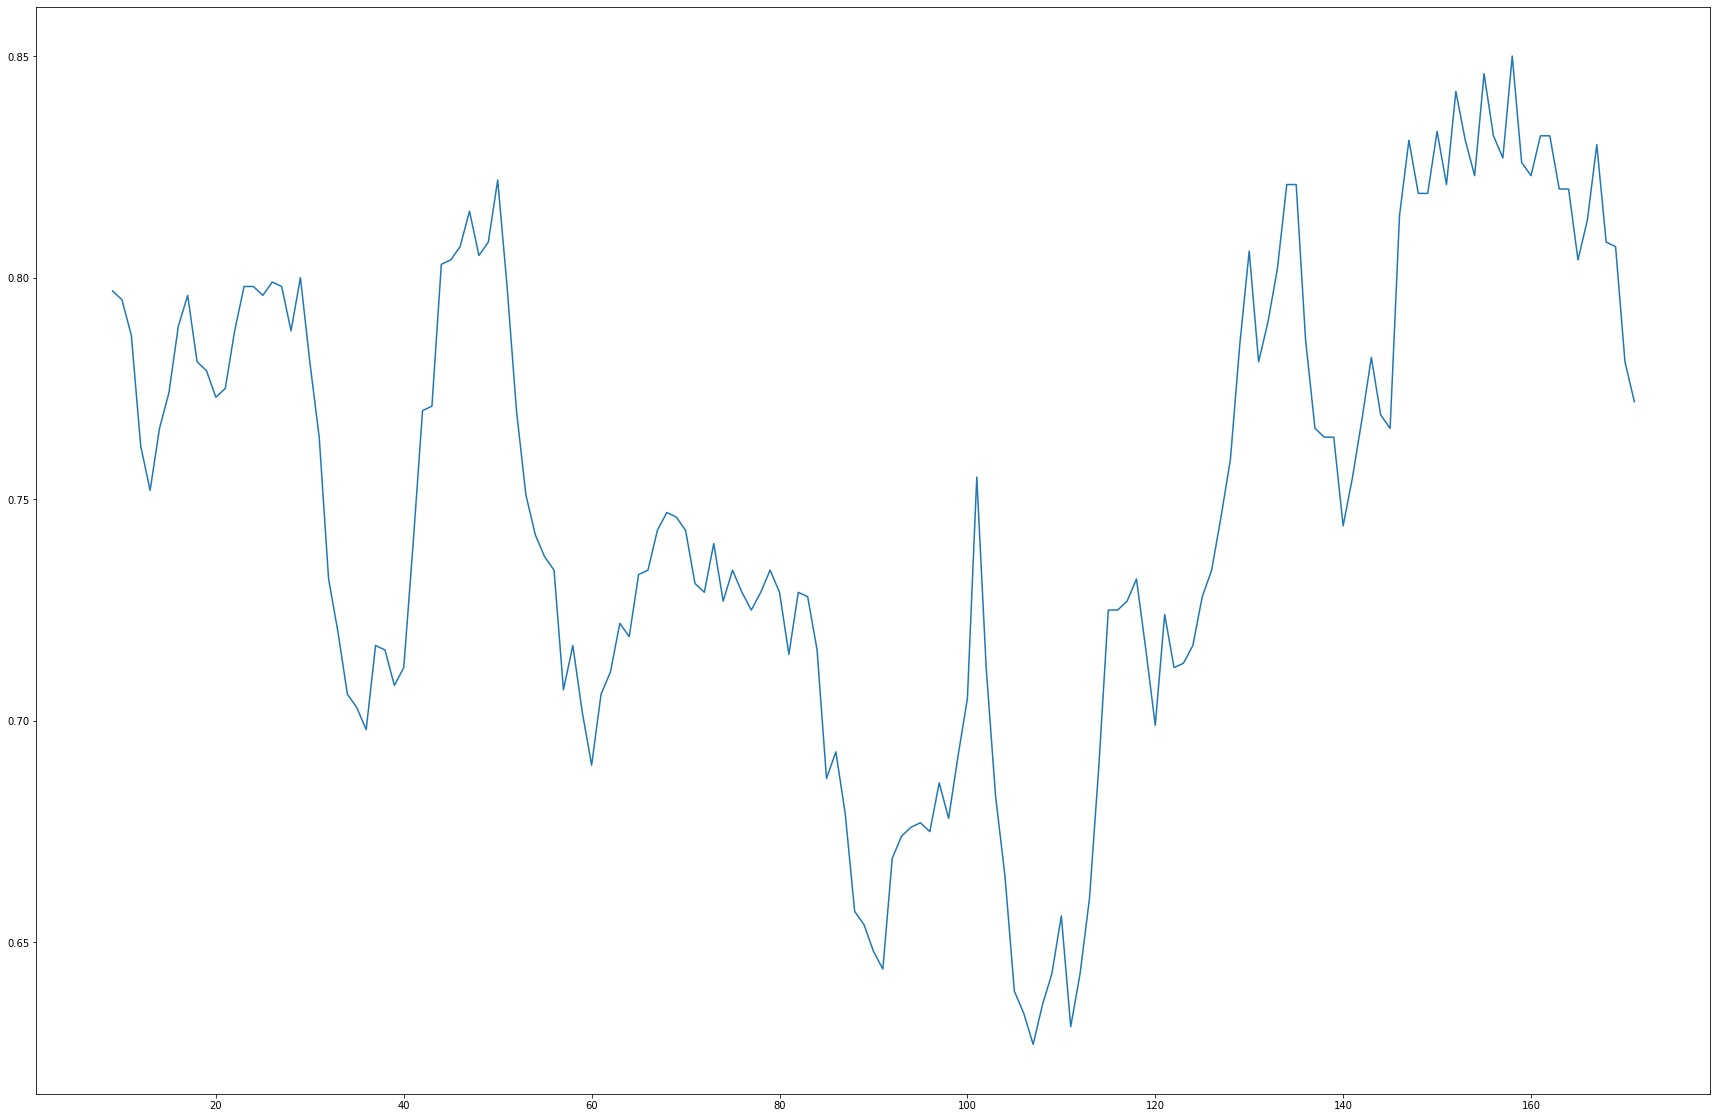

In [23]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.lineplot(x=list(range(len(moving_balls_dots_smooth))), y=moving_balls_dots_smooth)

Kohli is facing waaaaayyy more dot ball recently then his normal, and than his best form period. 85% of his balls now are dots compared to 75% in what looks like average, and also 65% what seems like is best. So basically Kohli is getting bogged down and is not flowing his runs as freely as he should. 

Actually one thing I want to explore, possible manually, is the commentary of the first few cove drives that Kohli is playing in every innings. I want to see if he is forcing the issue or not. Furthermore, lets quickly graph the total number of balls Kohli is facing per innings. Lets see if this average has dropped significantly.

#### Total number of balls per inning

In [24]:
total_balls_faced = [x['balls_faced'] for x in kohli_innings]

In [38]:
average_balls_faced = af.cumulative_average(total_balls_faced)

In [39]:
moving_average_balls_faced = af.moving_average(total_balls_faced, window_size=10)

<AxesSubplot:>

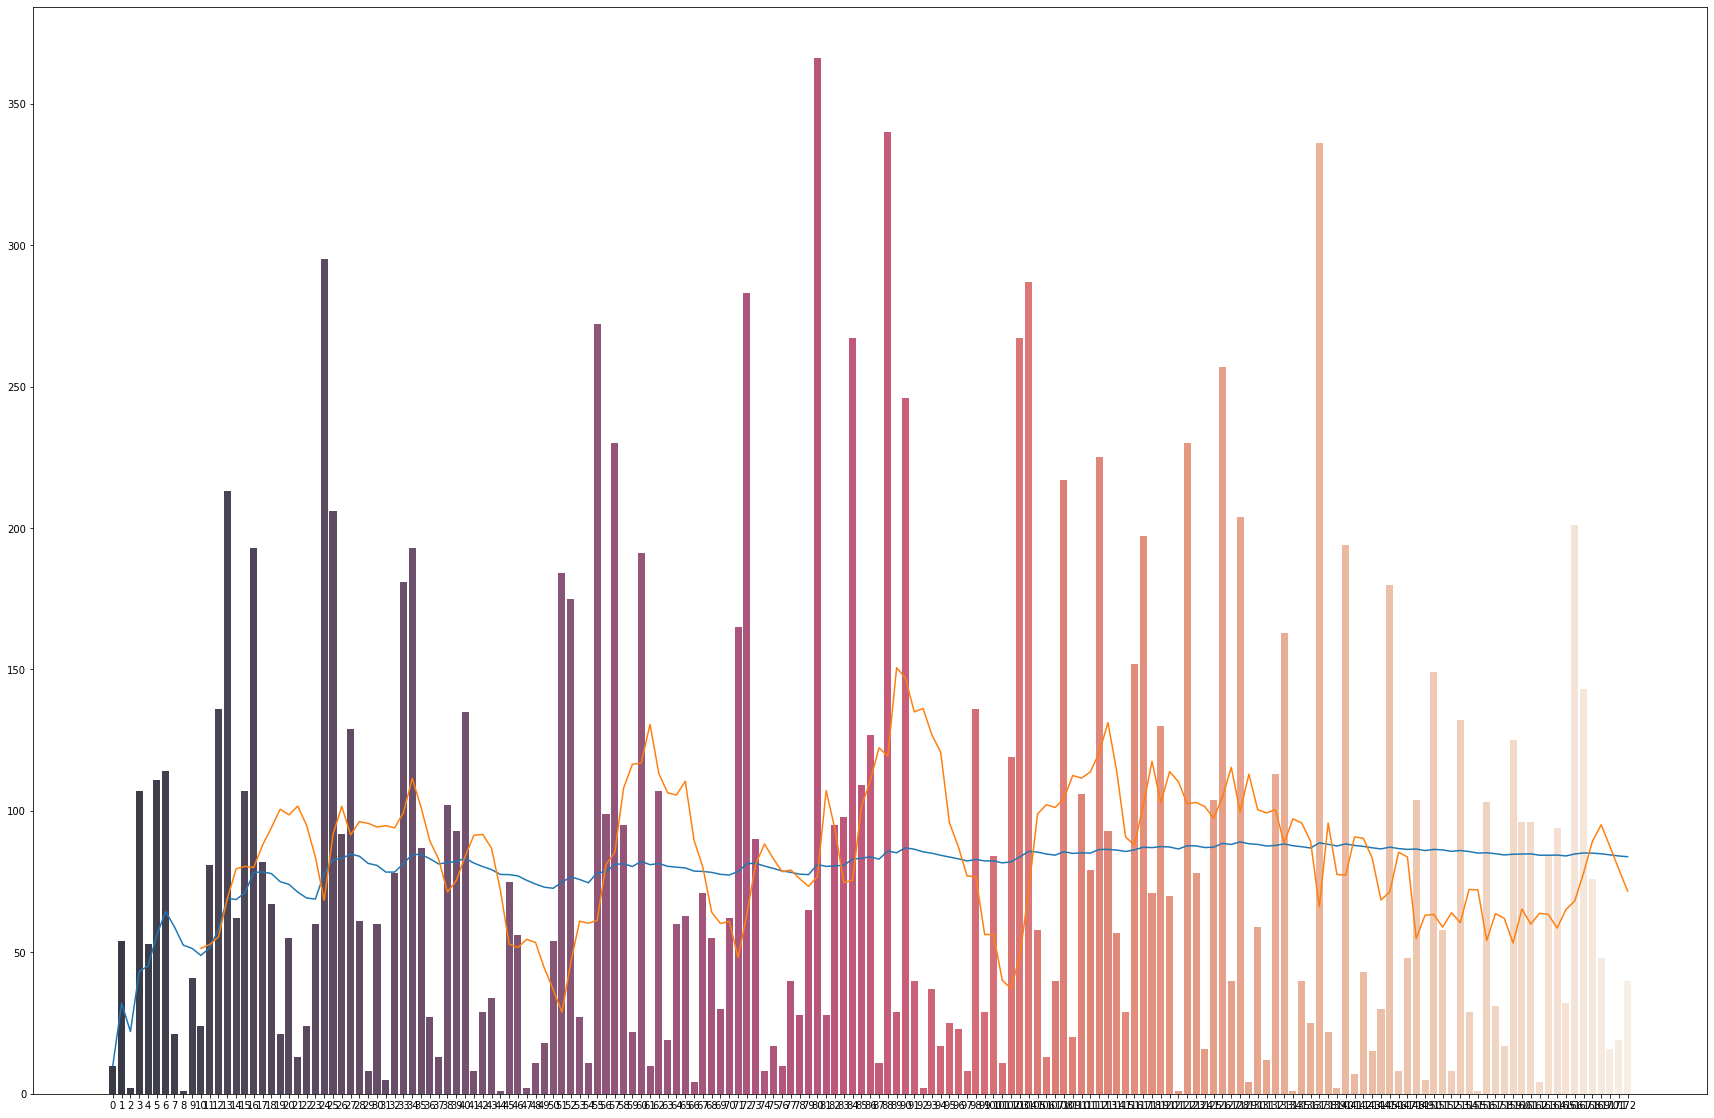

In [40]:
fig, ax1 = plt.subplots(figsize=(30,20)) 
sns.barplot(x=list(range(len(total_balls_faced))), y=total_balls_faced, alpha=0.8, ax=ax1, palette='rocket', dodge=False)
sns.lineplot(x=list(range(len(total_balls_faced))), y=average_balls_faced, ax=ax1)
sns.lineplot(x=list(range(len(total_balls_faced))), y=moving_average_balls_faced, ax=ax1)

The above graph is the average number of balls faced. We can see that it is going down in the period that is should be. 

## Cover drive commentary analysis

We want to now take a look possibly qualitatively on what kind of cover drives Kohli is playing early on in his innings. This will be to kind of settle the debate of this being a good or bad shot for Kohli. Basically we want to see if Kohli is getting 'antsy' when playing the cover drive. Is it that he is rushing his shots, is he jumping the gun on the cover drives?
We want to qualitatively see this from Kohli's shots.

Lets grab all the cover drive shots and then lets compare the commentary given for the first few (maybe 5) cover drives when Kohli is in form and when Kohli is out of form. To consider in form, lets consider innings when Kohli has scored a hundred. For out of form, we can consider innings after match 84 for Kohli. This is inning, 141 onwards.

In [22]:
def print_first_x_form(form_comms, x=5):
    wickets_ = 0
    beaten = 0
    beat = []
    edge = []
    miss = []
    for i,inning in enumerate(form_comms):
        print("Inning: ", i+1)
        for j,drive in enumerate(inning.commentTextItems.to_list()[:x]):
            if inning.isWicket.iloc[j]:
                wickets_ += 1
                #print(f"{utils.bcolors.FAIL}{utils.bcolors.BOLD}{j+1}. {drive}, {inning.batsmanRuns.iloc[j]}{utils.bcolors.ENDC}")
            elif 'beat' in drive or 'edge' in drive or 'miss' in drive:
                beaten += 1
                #print(f"{utils.bcolors.WARNING}{utils.bcolors.BOLD}{j+1}. {drive}, {inning.batsmanRuns.iloc[j]}{utils.bcolors.ENDC}")
                if 'beat' in drive:
                    print(drive)
                    beat.append(drive)
                elif 'edge' in drive:
                    edge.append(drive)
                elif 'miss' in drive:
                    miss.append(drive)
            else:
                pass
                #print(f"{j+1}. {drive}, {inning.batsmanRuns.iloc[j]}")
        #print()

    return wickets_, beaten, {'beat':beat, 'edge':edge, 'miss':miss}

In [61]:
hundreds = [i for i,x in enumerate(kohli_innings) if x['runs'] >= 100]

NameError: name 'kohli_innings' is not defined

In [7]:
kohli_comms_hundreds = [comms for i,comms in enumerate(kohli_comms) if i in hundreds]

In [10]:
cover_drives_in_form = af.search_shots_in_comms(kohli_comms_hundreds, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)

In [15]:
wickets_in_form = 0
for i,inning in enumerate(cover_drives_in_form):
    print("Inning: ", i+1)
    for j,drive in enumerate(inning.commentTextItems.to_list()[:5]):
        if inning.isWicket.iloc[j]:
            wickets_in_form += 1
            print(f"{utils.bcolors.FAIL}{j+1}. {drive}, {inning.batsmanRuns.iloc[j]}{utils.bcolors.ENDC}")
        else:
            print(f"{j+1}. {drive}, {inning.batsmanRuns.iloc[j]}")
    print()

Inning:  1
1. Motions forward and watchfully defends a pitched up delivery, 0
2. Leans in to the drive and eases the full delivery past extra cover, 2
3. Pushed away on the off side, 0
4. Reaches out to drive to the right of extra cover where hussey runs across and dives to save some runs, 1
5. Reaches out to a low full toss and pats it away to short extra cover, 0

Inning:  2
1. Virat beaten on the forward push, reaching away from the body to one leaving him with the angle from a good length, 0
2. Big stride out from virat as he gets low to defend a pitched up delivery towards covers, 0
3. The virat whip-drive, the crowd gets its release, floated up wide outside off, virat reaches out with a big stride and slams it through cover, 4
4. Superb ball to start off, holds its line after being angled in from wide of the crease, virat beaten as he pushes inside the line, 0
5. Crisply driven, leaning forward, reaching out to get to the line of the pitched up ball, finds extra cover, 0

Inning:

In [37]:
first_5 = []
for inning in cover_drives_in_form:
    first_5 += inning.batsmanRuns.to_list()[:5]

print('First five balls average when in form:')
sum(first_5)/len(first_5)

First five balls average when in form:


1.0

In [9]:
kohli_out_of_form_comms = kohli_comms[141:]

In [10]:
cover_drives_bad_form = af.search_shots_in_comms(kohli_out_of_form_comms, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)

In [110]:
wickets_post, beaten_post = print_first_x_form(cover_drives_bad_form, None)

Inning:  1
1. Overpitched, outside off. kohli bends low to drive, but can't get the perfect timing. finds mid off, 0
2. Full, on off, and he punches a front-foot drive past mid on. fielder has a bit of work to do, 2
3. What a dream debut so far!  the debutant gets the edge, and cap no 100 at first slip makes no mistake. fullish, outside off, inviting kohli for the drive. he looks to hit straight past the bowler, but the ball takes the outside edge instead. taylor tumbles backwards to take the catch, but ensures it stays safely within his hands, 0

Inning:  2
1. Through the gap! plays this drive uppishly, and there was a man at cover, but this was wide enough for kohli to still be in the middle. southee puts his hands on his head, 4
2. Full, outside off, and he presses forward to confidently defend, 0
3. Full, just outside off, and kohli steps across to work it towards mid-on, but the ball takes an edge and goes between the giant gap between gully and wideish first slip, 4
4. Full outsi

In [104]:
first_5_all_post = []
for inning in cover_drives_bad_form:
    first_5_all_post += inning.batsmanRuns.to_list()

print('First five balls average when out of form:')
sum(first_5_all_post)/len(first_5_all_post)

First five balls average when out of form:


0.7602040816326531

In [111]:
print('Length: ', len(first_5_all_post))
print('Wickets in this period ', wickets_post)
print('Beaten in this period', beaten_post)
print(f'Thats a wicket percentage of {wickets_post/len(first_5_all_post)} and inverse control percentage of {beaten_post/len(first_5_all_post)}')

Length:  392
Wickets in this period  14
Beaten in this period 63
Thats a wicket percentage of 0.03571428571428571 and inverse control percentage of 0.16071428571428573


In [112]:
kohli_pre_form_comms = kohli_comms[:141]

In [113]:
cover_drives_pre_form = af.search_shots_in_comms(kohli_pre_form_comms, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)

In [114]:
wickets_pre, beaten_pre = print_first_x_form(cover_drives_pre_form, None)

Inning:  1
1. And it wasn't long coming, virat brings out the whiplash extra cover drive off a fuller one but cannot beat the infield, 0
2. That is the end of virat's debut innings, he is gone nibbling at one outside off and baugh has gobbled up the appetiser before lunch, was some distance from virat, not much need to play at it, but for once virat pressed forward, and got so close to the ball that he had to play at it, and ended up getting a healthy edge through to the keeper, a happy bunch of west indians will take lunch,, 0

Inning:  2
1. Driven to bravo at cover, 0
2. Uppishly into the leg side, wide of short midwicket, early into the shot as he looked to cover-drive, 1
3. Punched away to cover, 0
4. Brute! absolute brute. hits a crack on a length, and jumps at his, beating his drive. dravid comes up and has a word with him, 0
5. Nice inside-out drive wide of mid-off for one, 1
6. In-between length, pushed away to cover, 0
7. This one doesn't quite come up, it's outside off, but a

In [115]:
first_5_all_pre = []
for inning in cover_drives_pre_form:
    first_5_all_pre += inning.batsmanRuns.to_list()

print('First five balls average normal form:')
sum(first_5_all_pre)/len(first_5_all_pre)

First five balls average normal form:


0.8776665215498476

In [116]:
print('Length: ', len(first_5_all_pre))
print('Wickets in this period ', wickets_pre)
print('Beaten in this period', beaten_pre)
print(f'Thats a wicket percentage of {wickets_pre/len(first_5_all_pre)} and inverse control percentage of {beaten_pre/len(first_5_all_pre)}')

Length:  2297
Wickets in this period  38
Beaten in this period 327
Thats a wicket percentage of 0.01654331737048324 and inverse control percentage of 0.14235959947757945


Ok, so from the above, though its a tiny amount in reality, we can see that the runs scored off the deliveries is lower. When Kohli is out of form. I also want to see how many of these shots are cover drives and also wickets. He seems to get our from cover drives more.

One thing to note here is that there arent really more times that Kohli is beaten in this period. So again indicating that throughout Kohli's career, he plays the ball far from his body, even early in his innings. The thing is that Kohli just seems to be getting out from that shot more.


Actually, if you consider ALL drives and just not the first 5 that he plays, then the numbers are a bit more stark, he is getting out twice as often with his cover drives, but he seems to be playing and missing only slighlty more. So basically he is playing the cover drive forcefully, but he doesnt seem to be being beaten more by the drives, and he is not really getting out earlier to the drives.

In [117]:
wickets_pre_5, beaten_pre_5 = print_first_x_form(cover_drives_pre_form, 5)

Inning:  1
1. And it wasn't long coming, virat brings out the whiplash extra cover drive off a fuller one but cannot beat the infield, 0
2. That is the end of virat's debut innings, he is gone nibbling at one outside off and baugh has gobbled up the appetiser before lunch, was some distance from virat, not much need to play at it, but for once virat pressed forward, and got so close to the ball that he had to play at it, and ended up getting a healthy edge through to the keeper, a happy bunch of west indians will take lunch,, 0

Inning:  2
1. Driven to bravo at cover, 0
2. Uppishly into the leg side, wide of short midwicket, early into the shot as he looked to cover-drive, 1
3. Punched away to cover, 0
4. Brute! absolute brute. hits a crack on a length, and jumps at his, beating his drive. dravid comes up and has a word with him, 0
5. Nice inside-out drive wide of mid-off for one, 1

Inning:  3

Inning:  4
1. Kohli leans out and drives into the off side with the spin., 0
2. Good ball, 

In [118]:
wickets_post_5, beaten_post_5 = print_first_x_form(cover_drives_bad_form, 5)

Inning:  1
1. Overpitched, outside off. kohli bends low to drive, but can't get the perfect timing. finds mid off, 0
2. Full, on off, and he punches a front-foot drive past mid on. fielder has a bit of work to do, 2
3. What a dream debut so far!  the debutant gets the edge, and cap no 100 at first slip makes no mistake. fullish, outside off, inviting kohli for the drive. he looks to hit straight past the bowler, but the ball takes the outside edge instead. taylor tumbles backwards to take the catch, but ensures it stays safely within his hands, 0

Inning:  2
1. Through the gap! plays this drive uppishly, and there was a man at cover, but this was wide enough for kohli to still be in the middle. southee puts his hands on his head, 4
2. Full, outside off, and he presses forward to confidently defend, 0
3. Full, just outside off, and kohli steps across to work it towards mid-on, but the ball takes an edge and goes between the giant gap between gully and wideish first slip, 4
4. Full outsi

In [120]:
l_pre = sum([5 if len(x) > 4 else len(x) for x in cover_drives_pre_form])
print('Pre first 5')
print('Length of period: ', l_pre)
print('Wickets in this period ', wickets_pre_5)
print('Beaten in this period', beaten_pre_5)
print(f'Thats a wicket percentage of {wickets_pre_5/l_pre} and inverse control percentage of {beaten_pre_5/l_pre}')

Pre first 5
Length of period:  572
Wickets in this period  8
Beaten in this period 97
Thats a wicket percentage of 0.013986013986013986 and inverse control percentage of 0.16958041958041958


In [121]:
l = sum([5 if len(x) > 4 else len(x) for x in cover_drives_bad_form])
print('Post first 5')
print('Length of period: ',l)
print('Wickets in this period ', wickets_post_5)
print('Beaten in this period', beaten_post_5)
print(f'Thats a wicket percentage of {wickets_post_5/l} and inverse control percentage of {beaten_post_5/l}')

Post first 5
Length of period:  142
Wickets in this period  5
Beaten in this period 20
Thats a wicket percentage of 0.035211267605633804 and inverse control percentage of 0.14084507042253522


# Cover Drive Misses and Edges

In [16]:
kohli_pre_form_comms = kohli_comms[:141]
kohli_post_form_comms = kohli_comms[141:]

cover_drives_pre_form = af.search_shots_in_comms(kohli_pre_form_comms, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)
cover_drives_post_form = af.search_shots_in_comms(kohli_post_form_comms, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)

#wickets_pre, beaten_pre, breakdown_pre = print_first_x_form(cover_drives_pre_form, None)
#wickets_post, beaten_post, breakdown_post = print_first_x_form(cover_drives_post_form, None)

In [8]:
# Cover drive analysis is wrong, need to search based on when Kohli was driving the ball and was beaten, 
# rather than searching just for when the commentary has beat in it, because in those cases, 
# we also catch cases when Kohli plays a good drive and then is simply beaten. 
# Therefore we need to use our search comms function to find the drives in which Kohli is actually beaten and not beats a fielder, we can again set up, coverdrive selection words
# and exclusion words and etc.
cover_drive_beat_primary = [
    'beaten'
]
cover_drive_beat_search = [
    'edged',
    ('wicket', 0.25),
    ('edge', 0.25),
    ('miss', 0.25),
    'beats[\s]{0,1}[\s\w\'\-\,]{0,}(?:edge|kohli|batsman|drive)',
    'beat[\s]{0,1}[\s\w\'\-\,]{0,}(?:edge|kohli|batsman|drive)',
    'beating[\s]{0,1}[\s\w\'\-\,]{0,}(?:edge|drive|shot)',
    ('beat him', 0.25),
    'beats him',
    'attempt[\s\w\'\-\,]{0,}(?:drive)',
    '(?:get|find|take|grazing|kiss|got)[\s]{0,1}[\s\w\'\-\,]{0,}(?:edge)',
    'edge[\s]{0,1}[\s\w\'\-\,]{0,}(?:slip|gully)',
    ('loose shot', 0.25),
    ('drop', 0.25),
    ('slip', 0.25),
    ('(?:push|drive)[\s]{0,1}[\s\w\'\-\,]{0,}away[\s]{0,1}[\s\w\'\-\,]{0,}body', 0.25),
    '(?:catch|caught)[\s\w\'\-\,]{0,}(?:slip|gully)'
    #outside edge, inside edge
]
cover_drive_beat_exclude = [
    'nicely', 
    ('beats[\s]{0,1}[\s\w]{0,} (?:fielder|bowler|man|cover|point)'),
    'top shot'
]

In [18]:
cover_drives_beaten_pre = af.search_shots_in_comms(cover_drives_pre_form, cover_drive_beat_search, cover_drive_beat_exclude, cover_drive_beat_primary, threshold=0.49)
cover_drives_beaten_post = af.search_shots_in_comms(cover_drives_post_form, cover_drive_beat_search, cover_drive_beat_exclude, cover_drive_beat_primary, threshold=0.49)

In [24]:
cover_drives_pre_form_wickets = []
for inning in cover_drives_pre_form:
    cover_drives_pre_form_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

cover_drives_beaten_pre_flat = []
for inning in cover_drives_beaten_pre:
    cover_drives_beaten_pre_flat += inning.commentTextItems.to_list()

cover_drives_pre_flat = []
for inning in cover_drives_pre_form:
    cover_drives_pre_flat += inning.commentTextItems.to_list()

cover_drives_beaten_pre_flat += [x for x in cover_drives_pre_form_wickets if x not in cover_drives_beaten_pre_flat]

print(len(cover_drives_pre_form_wickets))
print(len(cover_drives_beaten_pre_flat))
print(len(cover_drives_pre_flat))

print('Percentage of cover drives where Kohli is beaten, pre form: ',(len(cover_drives_beaten_pre_flat)/len(cover_drives_pre_flat)))

38
253
2297
Percentage of cover drives where Kohli is beaten, pre form:  0.11014366565084893


In [25]:
cover_drives_post_form_wickets = []
for inning in cover_drives_post_form:
    cover_drives_post_form_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

cover_drives_beaten_post_flat = []
for inning in cover_drives_beaten_post:
    cover_drives_beaten_post_flat += inning.commentTextItems.to_list()

cover_drives_post_flat = []
for inning in cover_drives_post_form:
    cover_drives_post_flat += inning.commentTextItems.to_list()

cover_drives_beaten_post_flat += [x for x in cover_drives_post_form_wickets if x not in cover_drives_beaten_post_flat]

print(len(cover_drives_post_form_wickets))
print(len(cover_drives_beaten_post_flat))
print(len(cover_drives_post_flat))

print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_beaten_post_flat)/len(cover_drives_post_flat)))

14
55
392
Percentage of cover drives where Kohli is beaten, post form:  0.14030612244897958


In [74]:
cover_drives_beaten_post_flat

['What a dream debut so far!  the debutant gets the edge, and cap no 100 at first slip makes no mistake. fullish, outside off, inviting kohli for the drive. he looks to hit straight past the bowler, but the ball takes the outside edge instead. taylor tumbles backwards to take the catch, but ensures it stays safely within his hands',
 'Full, just outside off, and kohli steps across to work it towards mid-on, but the ball takes an edge and goes between the giant gap between gully and wideish first slip',
 "And he has got kohli first up but kohli reviews with one second to go. this is desperate reviewing, and he will be hoping there is an umpire's call on it because there is no way this is not out. this is just too good from southee. pitches it up for the outswinger, the ball seams back in after pitching, beats the inside edge on the drive, and he is hit plumb in front. wastes the review. will hate it for rahane or pujara to get a stinker from the umpire now. back to the delivery: this is

In [65]:
cover_drives_post_flat

["Overpitched, outside off. kohli bends low to drive, but can't get the perfect timing. finds mid off",
 'Full, on off, and he punches a front-foot drive past mid on. fielder has a bit of work to do',
 'What a dream debut so far!  the debutant gets the edge, and cap no 100 at first slip makes no mistake. fullish, outside off, inviting kohli for the drive. he looks to hit straight past the bowler, but the ball takes the outside edge instead. taylor tumbles backwards to take the catch, but ensures it stays safely within his hands',
 'Through the gap! plays this drive uppishly, and there was a man at cover, but this was wide enough for kohli to still be in the middle. southee puts his hands on his head',
 'Full, outside off, and he presses forward to confidently defend',
 'Full, just outside off, and kohli steps across to work it towards mid-on, but the ball takes an edge and goes between the giant gap between gully and wideish first slip',
 'Full outside off, and he pushes away from his 

In [67]:
[x for x in cover_drives_post_flat if x not in cover_drives_beaten_post_flat]

["Overpitched, outside off. kohli bends low to drive, but can't get the perfect timing. finds mid off",
 'Full, on off, and he punches a front-foot drive past mid on. fielder has a bit of work to do',
 'Through the gap! plays this drive uppishly, and there was a man at cover, but this was wide enough for kohli to still be in the middle. southee puts his hands on his head',
 'Full, outside off, and he presses forward to confidently defend',
 'Full outside off, and he pushes away from his body to wide mid off',
 'Full, outside off stump, and he presses forward to drive. in the air and falls just short of wide mid off',
 'Full, outside off, and going straight through to the keeper',
 'Full, just outside off, and he presses forward to check a drive to mid off',
 "Full, just outside off, and kohli uses his wrist to open the bat's face before driving through the covers",
 'Full, just outside off stump. and defended towards cover',
 'Full, on off stump. and tapped with soft hands to cover. st

In [26]:
iffy_ones=[
    "And he goes for the drive, gets a big outside edge, but it bounces short of gully. big stride out to get front foot to the pitch, but he wasn't fully in control of that",
    "Again off a thickish outside edge but this one's along the ground to gully. riveting stuff from kg rabada",
    "Soft hands there. kohli pushes at this incoming delivery away from the body, but the ball doesn't come in as much as expected. the edge goes right down and past third slip and goes for four despite a spirited chase from burns",
    "Flies over gully as kohli chases this outside off! pretty wide outside off, not much footwork as he reaches out for it, and a thick edge goes way over gully for four"
]

ind, scores = af.search_for_phrases(iffy_ones, cover_drive_beat_search, cover_drive_beat_exclude, cover_drive_beat_primary, threshold=0.49)

In [27]:
ind

[1, 1, 1, 1]

In [28]:
scores

[1, 0.75, 1, 0.75]

In [9]:
#Lets split the pre-career into further sections so that we can make a line graph, split pre career into thirds. By years this will be...
kohli_matches_1 = wsf.get_player_match_list(KOHLI_ID, '2011-01-01:2013-12-31')
kohli_matches_2 = wsf.get_player_match_list(KOHLI_ID, '2014-01-01:2016-12-31')
kohli_matches_3 = wsf.get_player_match_list(KOHLI_ID, '2017-01-01:2019-12-31')

kohli_comms_1 = af.get_player_contributions(KOHLI_ID, kohli_matches_1, _type='bat', by_innings=True, is_object_id=True)
kohli_comms_2 = af.get_player_contributions(KOHLI_ID, kohli_matches_2, _type='bat', by_innings=True, is_object_id=True)
kohli_comms_3 = af.get_player_contributions(KOHLI_ID, kohli_matches_3, _type='bat', by_innings=True, is_object_id=True)

cover_drives_1 = af.search_shots_in_comms(kohli_comms_1, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)
cover_drives_2 = af.search_shots_in_comms(kohli_comms_2, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)
cover_drives_3 = af.search_shots_in_comms(kohli_comms_3, cover_drive_search_kw, cover_drive_exlude_words, primary_keywords=cover_drive_primary_kw, threshold=0.49)

In [10]:
cover_drives_beaten_1 = af.search_shots_in_comms(cover_drives_1, cover_drive_beat_search, cover_drive_beat_exclude, cover_drive_beat_primary, threshold=0.49)
cover_drives_beaten_2 = af.search_shots_in_comms(cover_drives_2, cover_drive_beat_search, cover_drive_beat_exclude, cover_drive_beat_primary, threshold=0.49)
cover_drives_beaten_3 = af.search_shots_in_comms(cover_drives_3, cover_drive_beat_search, cover_drive_beat_exclude, cover_drive_beat_primary, threshold=0.49)

In [20]:
cover_drives_1_wickets = []
for inning in cover_drives_1:
    cover_drives_1_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

cover_drives_beaten_1_flat = []
for inning in cover_drives_beaten_1:
    cover_drives_beaten_1_flat += inning.commentTextItems.to_list()

cover_drives_1_flat = []
for inning in cover_drives_1:
    cover_drives_1_flat += inning.commentTextItems.to_list()

cover_drives_beaten_1_flat += [x for x in cover_drives_1_wickets if x not in cover_drives_beaten_1_flat]

comms_1_wickets = []
for inning in kohli_comms_1:
    comms_1_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

print(len(cover_drives_1_wickets))
print(len(cover_drives_beaten_1_flat))
print(len(cover_drives_1_flat))
print(len(comms_1_wickets))
print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_1_wickets)/len(cover_drives_1_flat)))
print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_beaten_1_flat)/len(cover_drives_1_flat)))
print('Percentage of wickets from cover drives', (len(cover_drives_1_wickets)/len(comms_1_wickets)))

9
46
495
35
Percentage of cover drives where Kohli is beaten, post form:  0.01818181818181818
Percentage of cover drives where Kohli is beaten, post form:  0.09292929292929293
Percentage of wickets from cover drives 0.2571428571428571


In [21]:
cover_drives_2_wickets = []
for inning in cover_drives_2:
    cover_drives_2_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

cover_drives_beaten_2_flat = []
for inning in cover_drives_beaten_2:
    cover_drives_beaten_2_flat += inning.commentTextItems.to_list()

cover_drives_2_flat = []
for inning in cover_drives_2:
    cover_drives_2_flat += inning.commentTextItems.to_list()

cover_drives_beaten_2_flat += [x for x in cover_drives_2_wickets if x not in cover_drives_beaten_2_flat]

comms_2_wickets = []
for inning in kohli_comms_2:
    comms_2_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

print(len(cover_drives_2_wickets))
print(len(cover_drives_beaten_2_flat))
print(len(cover_drives_2_flat))
print(len(comms_2_wickets))
print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_2_wickets)/len(cover_drives_2_flat)))
print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_beaten_2_flat)/len(cover_drives_2_flat)))
print('Percentage of wickets from cover drives', (len(cover_drives_2_wickets)/len(comms_2_wickets)))

17
93
834
51
Percentage of cover drives where Kohli is beaten, post form:  0.02038369304556355
Percentage of cover drives where Kohli is beaten, post form:  0.11151079136690648
Percentage of wickets from cover drives 0.3333333333333333


In [22]:
cover_drives_3_wickets = []
for inning in cover_drives_3:
    cover_drives_3_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

cover_drives_beaten_3_flat = []
for inning in cover_drives_beaten_3:
    cover_drives_beaten_3_flat += inning.commentTextItems.to_list()

cover_drives_3_flat = []
for inning in cover_drives_3:
    cover_drives_3_flat += inning.commentTextItems.to_list()

cover_drives_beaten_3_flat += [x for x in cover_drives_3_wickets if x not in cover_drives_beaten_3_flat]

comms_3_wickets = []
for inning in kohli_comms_3:
    comms_3_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

print(len(cover_drives_3_wickets))
print(len(cover_drives_beaten_3_flat))
print(len(cover_drives_3_flat))
print(len(comms_3_wickets))
print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_3_wickets)/len(cover_drives_3_flat)))
print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_beaten_3_flat)/len(cover_drives_3_flat)))
print('Percentage of wickets from cover drives', (len(cover_drives_3_wickets)/len(comms_3_wickets)))

12
114
968
47
Percentage of cover drives where Kohli is beaten, post form:  0.012396694214876033
Percentage of cover drives where Kohli is beaten, post form:  0.11776859504132231
Percentage of wickets from cover drives 0.2553191489361702


In [24]:
cover_drives_post_form_wickets = []
for inning in cover_drives_post_form:
    cover_drives_post_form_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

cover_drives_beaten_post_flat = []
for inning in cover_drives_beaten_post:
    cover_drives_beaten_post_flat += inning.commentTextItems.to_list()

cover_drives_post_flat = []
for inning in cover_drives_post_form:
    cover_drives_post_flat += inning.commentTextItems.to_list()

cover_drives_beaten_post_flat += [x for x in cover_drives_post_form_wickets if x not in cover_drives_beaten_post_flat]

comms_4_wickets = []
for inning in kohli_post_form_comms:
    comms_4_wickets += inning[inning.isWicket==True].commentTextItems.to_list()

print(len(cover_drives_post_form_wickets))
print(len(cover_drives_beaten_post_flat))
print(len(cover_drives_post_flat))
print(len(comms_4_wickets))
print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_post_form_wickets)/len(cover_drives_post_flat)))
print('Percentage of cover drives where Kohli is beaten, post form: ',(len(cover_drives_beaten_post_flat)/len(cover_drives_post_flat)))
print('Percentage of wickets from cover drives', (len(cover_drives_post_form_wickets)/len(comms_4_wickets)))

14
57
397
36
Percentage of cover drives where Kohli is beaten, post form:  0.03526448362720403
Percentage of cover drives where Kohli is beaten, post form:  0.14357682619647355
Percentage of wickets from cover drives 0.3888888888888889


## Average runs scored from coverdrive